# Machine Learning Final Project: Multiclass Image Recgonition #
## Authors: Michael, Jay ##
### April 26, 2025 ###
**Task**: Multiclass image classification\
**Dataset**: food-101\
**Description**: Experiment on training a multiclass image classifier on food images

## 1. Environment setup ##

In [1]:
import tensorflow as tf
print(tf.__version__)

2025-04-30 17:17:29.097173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 17:17:29.173832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746047849.212008    1552 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746047849.221911    1552 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746047849.288429    1552 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2.19.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17971874147177163225
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9446686720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9525393276017448082
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1746047851.408552    1552 gpu_device.cc:2019] Created device /device:GPU:0 with 9009 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
import os
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.regularizers import l2

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandomBrightness, RandomContrast

In [4]:
os.chdir('/home/J/ml_project/')
print(os.getcwd())

/home/J/ml_project


In [5]:
# Define paths
train_dir = "food-101/train"
val_dir = "food-101/validation"

# Image sizes
IMG_SIZE = (299, 299)

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    label_mode='categorical',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)



Found 80800 files belonging to 101 classes.


I0000 00:00:1746047857.890374    1552 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9009 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 20200 files belonging to 101 classes.


In [6]:
for images, labels in train_ds.take(1):
    print(labels[0])

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.], shape=(101,), dtype=float32)


2025-04-30 17:17:39.976420: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 2. Unsupervised Analysis ##

### 2.1 Dataset labels ###

In [7]:
# List all 101 food categories
food_categories = [name for name in os.listdir(train_dir)
                   if os.path.isdir(os.path.join(train_dir, name))]

total_images = 0

# Print total count + all food categories
print(f"\nTotal number of food categories: {len(food_categories)}")
print("Food categories:")
for category in food_categories:
    category_path = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(category_path)
                   if os.path.isfile(os.path.join(category_path, f))]
    count = len(image_files)
    total_images += count
    print(f"- {category}: {count} images")

print(f"Total number of images: {total_images}")


Total number of food categories: 101
Food categories:
- chocolate_mousse: 800 images
- ramen: 800 images
- sashimi: 800 images
- lobster_roll_sandwich: 800 images
- bruschetta: 800 images
- cheesecake: 800 images
- spring_rolls: 800 images
- pho: 800 images
- red_velvet_cake: 800 images
- gyoza: 800 images
- hummus: 800 images
- french_toast: 800 images
- chicken_curry: 800 images
- churros: 800 images
- cannoli: 800 images
- risotto: 800 images
- caesar_salad: 800 images
- foie_gras: 800 images
- miso_soup: 800 images
- onion_rings: 800 images
- cup_cakes: 800 images
- apple_pie: 800 images
- club_sandwich: 800 images
- cheese_plate: 800 images
- pork_chop: 800 images
- edamame: 800 images
- donuts: 800 images
- deviled_eggs: 800 images
- spaghetti_carbonara: 800 images
- beef_tartare: 800 images
- hamburger: 800 images
- beef_carpaccio: 800 images
- caprese_salad: 800 images
- frozen_yogurt: 800 images
- tuna_tartare: 800 images
- breakfast_burrito: 800 images
- gnocchi: 800 images


### 2.2 Generate 5 images, metadata from dataset ###

File: food-101/train/tuna_tartare/1941378.jpg
Size: (512, 512)
Shape: (512, 512, 3)
Pixel Range: 0 - 255


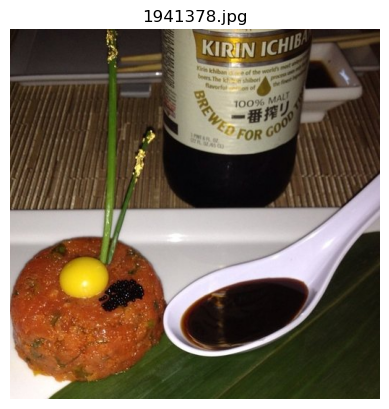

--------------------------------------------------
File: food-101/train/breakfast_burrito/2953215.jpg
Size: (512, 512)
Shape: (512, 512, 3)
Pixel Range: 0 - 255


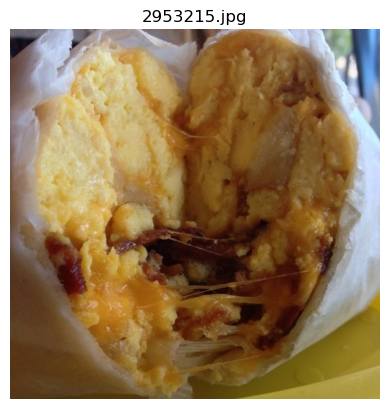

--------------------------------------------------
File: food-101/train/garlic_bread/2918236.jpg
Size: (512, 512)
Shape: (512, 512, 3)
Pixel Range: 0 - 255


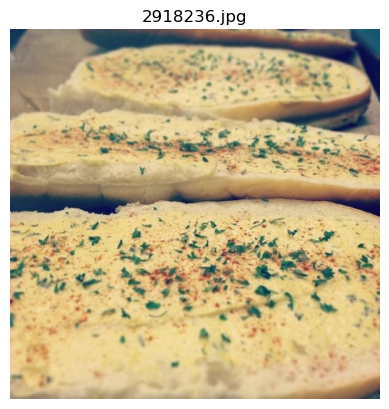

--------------------------------------------------
File: food-101/train/ceviche/1203618.jpg
Size: (512, 512)
Shape: (512, 512, 3)
Pixel Range: 0 - 255


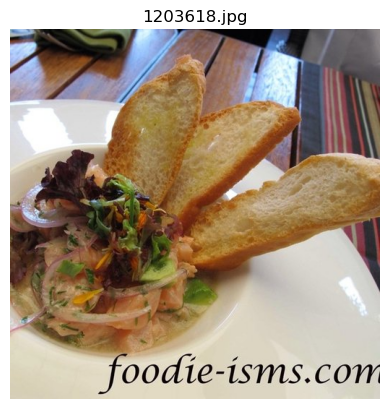

--------------------------------------------------
File: food-101/train/hamburger/2250663.jpg
Size: (512, 512)
Shape: (512, 512, 3)
Pixel Range: 0 - 255


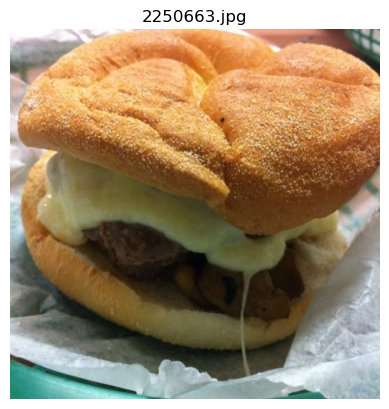

--------------------------------------------------


In [8]:
# Collect a few sample image paths at random
sample_paths = []
for _ in range(5):  # Show 5 random samples
    category = random.choice(food_categories)
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    if images:
        img_name = random.choice(images)
        img_path = os.path.join(category_path, img_name)
        sample_paths.append(img_path)

# Display images and print their properties
for path in sample_paths:
    img = Image.open(path)
    img_array = np.array(img)

    print(f"File: {path}")
    print(f"Size: {img.size}")  # (width, height)
    print(f"Shape: {img_array.shape}")
    print(f"Pixel Range: {img_array.min()} - {img_array.max()}")

    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(path))
    plt.show()
    print("-" * 50)

### 2.3 Additional Analysis ###

1. Plot individual features to understand their distribution (e.g., histograms or density plots)\
2. Plot individual features and their relationship with the target variable.\
3. Create a correlation matrix to analyze relationships between features.

In [15]:

# Load in a subset of the data for this analysis 
max_per_class = 50
IMG_SIZE = (64, 64)

data = []
labels = []

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    count = 0
    for img_name in os.listdir(class_dir):
        if count >= max_per_class:
            break
        img_path = os.path.join(class_dir, img_name)
        try:
            img = Image.open(img_path).resize(IMG_SIZE)
            img_np = np.array(img)
            features = {
                'mean': np.mean(img_np),
                'std': np.std(img_np),
                'r_mean': np.mean(img_np[:, :, 0]),
                'g_mean': np.mean(img_np[:, :, 1]),
                'b_mean': np.mean(img_np[:, :, 2]),
                'label': class_name
            }
            data.append(features)
            count += 1
        except:
            continue

df = pd.DataFrame(data)



     

In [16]:
print(df)

            mean        std      r_mean      g_mean      b_mean  \
0     150.659424  84.757397  171.529297  143.745605  136.703369   
1      47.125814  48.356395   80.866943   35.938721   24.571777   
2     105.881592  71.035110  123.931885  104.502686   89.210205   
3     104.526855  62.573614  123.928223   99.852295   89.800049   
4      76.658610  80.735487   84.735596   73.216553   72.023682   
...          ...        ...         ...         ...         ...   
5045   67.653076  69.476740   79.144043   71.242432   52.572754   
5046  115.827311  55.752753  126.352295  120.334229  100.795410   
5047  142.391113  70.275702  160.154541  154.664551  112.354248   
5048  127.026286  56.785229  130.379150  132.052002  118.647705   
5049  186.550049  51.403658  207.566162  191.575928  160.508057   

                 label  
0     chocolate_mousse  
1     chocolate_mousse  
2     chocolate_mousse  
3     chocolate_mousse  
4     chocolate_mousse  
...                ...  
5045          scallo

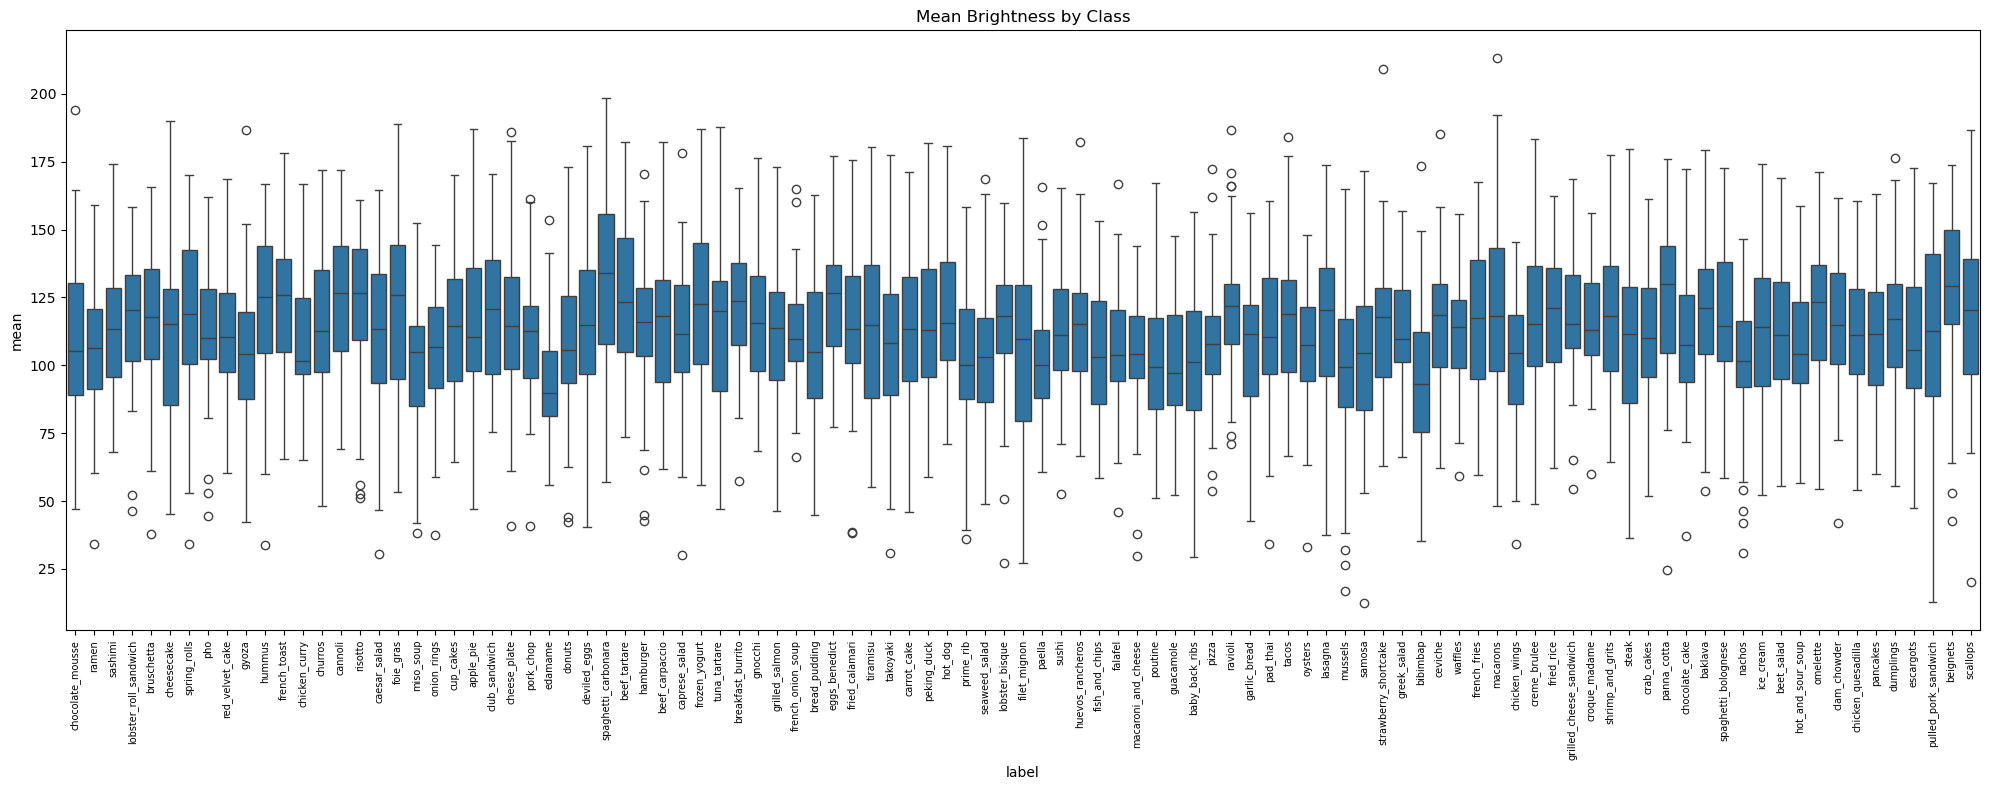

In [17]:
# Feature Distributions
top_classes = df['label'].value_counts().head(101).index
subset = df[df['label'].isin(top_classes)]

plt.figure(figsize=(20, 8))
sns.boxplot(data=subset, x='label', y='mean')
plt.title("Mean Brightness by Class")
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

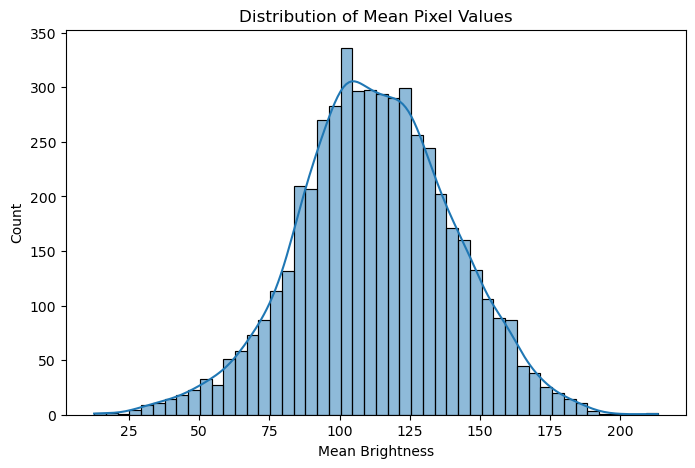

In [18]:
# Features vs. target
plt.figure(figsize=(8, 5))
sns.histplot(df['mean'], kde=True)
plt.title("Distribution of Mean Pixel Values")
plt.xlabel("Mean Brightness")
plt.show()

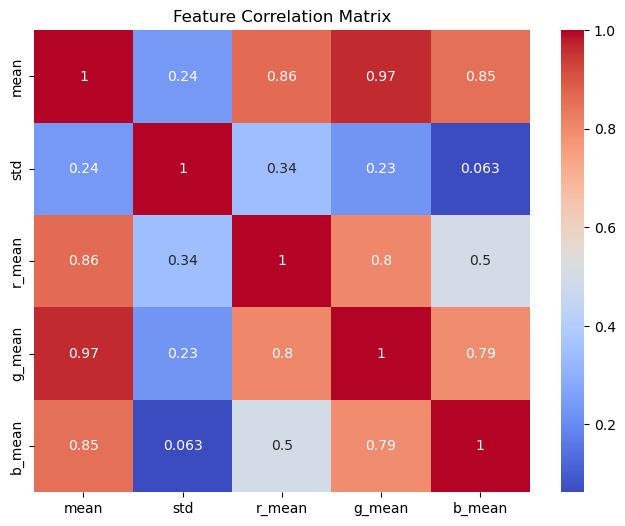

In [19]:
# Correlation Matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

### 2.4 PCA ###

In [7]:
# Some PCA specific config/setup
N_SAMPLES = 80800
N_COMPONENTS = 500
PCA_BATCH_SIZE = 512
N_CHANNELS = 3

ipca = IncrementalPCA(n_components=N_COMPONENTS)

def preprocess_and_flatten(images):
    return (images.numpy() / 255.0).reshape(-1, IMG_SIZE[0] * IMG_SIZE[1] * N_CHANNELS)
    
IMG_SIZE = (64, 64)  # much smaller, uses ~96% less memory
train_dir = "food-101/train"
val_dir = "food-101/validation"

def get_datasets():
    return (
        tf.keras.utils.image_dataset_from_directory(
            train_dir,
            image_size=IMG_SIZE,
            batch_size=32,
            label_mode='categorical',
            shuffle=True
        ),
        tf.keras.utils.image_dataset_from_directory(
            val_dir,
            image_size=IMG_SIZE,
            batch_size=32,
            label_mode='categorical',
            shuffle=False
        )
    )

In [8]:
from tqdm import tqdm
# Helper function to extract images and labels from a tf.data.Dataset
def extract_images(dataset):
    images = []
    total_batches = tf.data.experimental.cardinality(dataset).numpy()
    for batch in tqdm(dataset, total=total_batches, desc="Extracting images"):
        imgs, _ = batch
        images.append(imgs.numpy())
    return np.concatenate(images, axis=0)



# 1. Extract images from datasets
train_ds, val_ds = get_datasets()
train_images = extract_images(train_ds)
val_images = extract_images(val_ds)

# 2. Flatten images (299x299x3 -> 268203 features per image)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)

# 3. Standardize the features
scaler = StandardScaler()
train_images_std = scaler.fit_transform(train_images_flat)
val_images_std = scaler.transform(val_images_flat)

Found 80800 files belonging to 101 classes.
Found 20200 files belonging to 101 classes.


Extracting images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [00:00<00:00, 926.40it/s]


In [9]:
for i in tqdm(range(0, train_images_std.shape[0], 512), desc="Fitting PCA"):
    batch = train_images_std[i:i+512]
    ipca.partial_fit(batch)

Fitting PCA: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [35:11<00:00, 13.36s/it]


In [10]:
# Transform
train_pca = np.vstack([
    ipca.transform(train_images_std[i:i+512])
    for i in tqdm(range(0, train_images_std.shape[0], 512), desc="Transforming PCA")
])

# train_pca and val_pca now contain the PCA-reduced representations
print("Train PCA shape:", train_pca.shape)

Transforming PCA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [04:04<00:00,  1.55s/it]

Train PCA shape: (80800, 500)


In [11]:
for i in tqdm(range(0, val_images_std.shape[0], 512), desc="Fitting PCA"):
    batch = val_images_std[i:i+512]
    ipca.partial_fit(batch)

Fitting PCA: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [08:51<00:00, 13.28s/it]


In [12]:
val_pca = np.vstack([
    ipca.transform(val_images_std[i:i+512])
    for i in tqdm(range(0, val_images_std.shape[0], 512), desc="Transforming PCA")
])

# train_pca and val_pca now contain the PCA-reduced representations
print("Train PCA shape:", val_pca.shape)

Transforming PCA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:58<00:00,  1.46s/it]

Train PCA shape: (20200, 500)


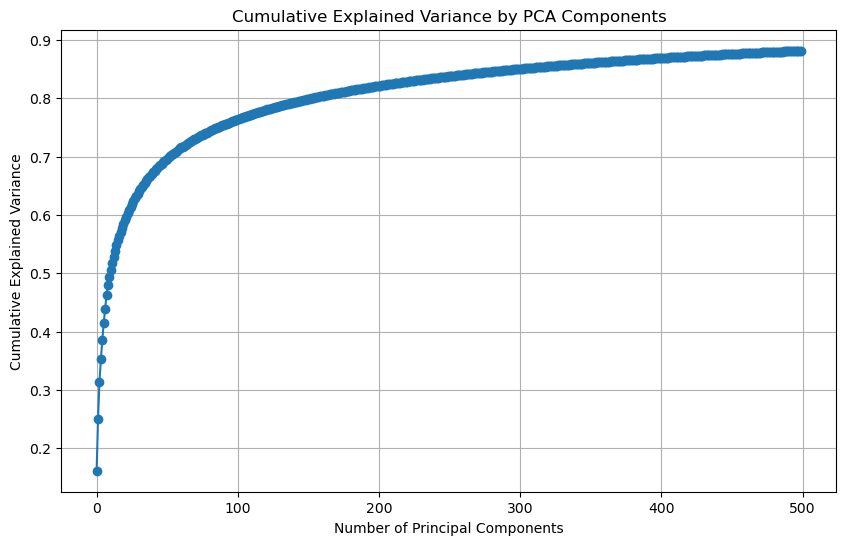

In [13]:
# Calculate the explained variance ratio from the PCA model
explained_variance_ratio = ipca.explained_variance_ratio_

# Plot the explained variance for each component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

## 3. Supervised Analysis: CNN ##

### 3.1 Preprocessing, Data Augmentation ###

In [7]:
# Normalize images
def preprocess(image, label): 
    image = tf.keras.applications.inception_v3.preprocess_input(image)  # Normalize to [-1, 1]
    return image, label

# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  
    RandomRotation(0.1),  
    RandomZoom(0.2),  
    RandomBrightness(0.2),  
    RandomContrast(0.2),  
    tf.keras.layers.Lambda(lambda x: tf.image.random_hue(x, 0.05)),
])

In [8]:
def get_num_classes(train_path):
    class_names = os.listdir(train_path)  # List of class directories
    class_names = [class_name for class_name in class_names if os.path.isdir(os.path.join(train_path, class_name))]
    return len(class_names)

In [9]:
# Image RGB channels
input_shape = IMG_SIZE + (3,)

# Number of labels
num_classes = get_num_classes('food-101/train')


In [10]:
# Apply data augmentation First
# did something completely stupid here. Redo this.
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Apply normalization after data augmentation
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Validation dataset uses no augmentation
val_ds = val_ds.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for better performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### 3.2 Convolutional neural network: Model_1: 3 Conv layers ###
Notes: Standard 3 conv layer CNN

#### 3.2.1 Model_1 definition ####
Variant: 3 conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: none\
characteristics: good baseline model for foundation\
observation: i know this works

In [13]:
# Model1 Definition
def create_model_1(input_shape, num_classes):
    model_1 = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # layers.Flatten(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model_1

In [14]:
# Create model
model_1 = create_model_1(input_shape, num_classes)

# Compile model
model_1.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model_1.summary()

# Train
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,125 (598.14 KB)

 Trainable params: 152,677 (596.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5


I0000 00:00:1745817005.474067   15932 service.cc:152] XLA service 0x795e64003840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745817005.474098   15932 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-04-28 01:10:05.525323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745817005.979416   15932 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-28 01:10:07.121222: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1956', 660 bytes spill stores, 664 bytes spill loads

2025-04-28 01:10:07.281385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

   3/2525 ━━━━━━━━━━━━━━━━━━━━ 2:58 71ms/step - accuracy: 0.0191 - loss: 5.0818 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1745817011.036496   15932 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 192s 73ms/step - accuracy: 0.0270 - loss: 4.6324 - precision: 0.2796 - recall: 5.2352e-04 - val_accuracy: 0.0874 - val_loss: 4.1117 - val_precision: 0.6640 - val_recall: 0.0041
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 182s 72ms/step - accuracy: 0.0769 - loss: 4.1682 - precision: 0.4406 - recall: 0.0031 - val_accuracy: 0.1112 - val_loss: 3.8942 - val_precision: 0.6062 - val_recall: 0.0116
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 184s 73ms/step - accuracy: 0.1111 - loss: 3.9254 - precision: 0.5434 - recall: 0.0088 - val_accuracy: 0.1346 - val_loss: 3.7976 - val_precision: 0.6513 - val_recall: 0.0196
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 184s 73ms/step - accuracy: 0.1391 - loss: 3.7656 - precision: 0.5859 - recall: 0.0159 - val_accuracy: 0.1786 - val_loss: 3.5368 - val_precision: 0.6465 - val_recall: 0.0296
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 186s 73ms/step - accuracy: 0.1598 - loss: 3.6532 - precision: 0.6070 - recall: 0.0228 - val_accuracy: 0.1822 

In [15]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.1711 - loss: 3.5170 - precision: 0.5472 - recall: 0.0467
Validation Loss: 3.4933922290802
Validation Accuracy: 0.1822277158498764
Validation Precision: 0.5817728042602539
Validation Recall: 0.046138614416122437


In [16]:
# Obtain history item keys(cuz tf gets a bit weird with naming keys)
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


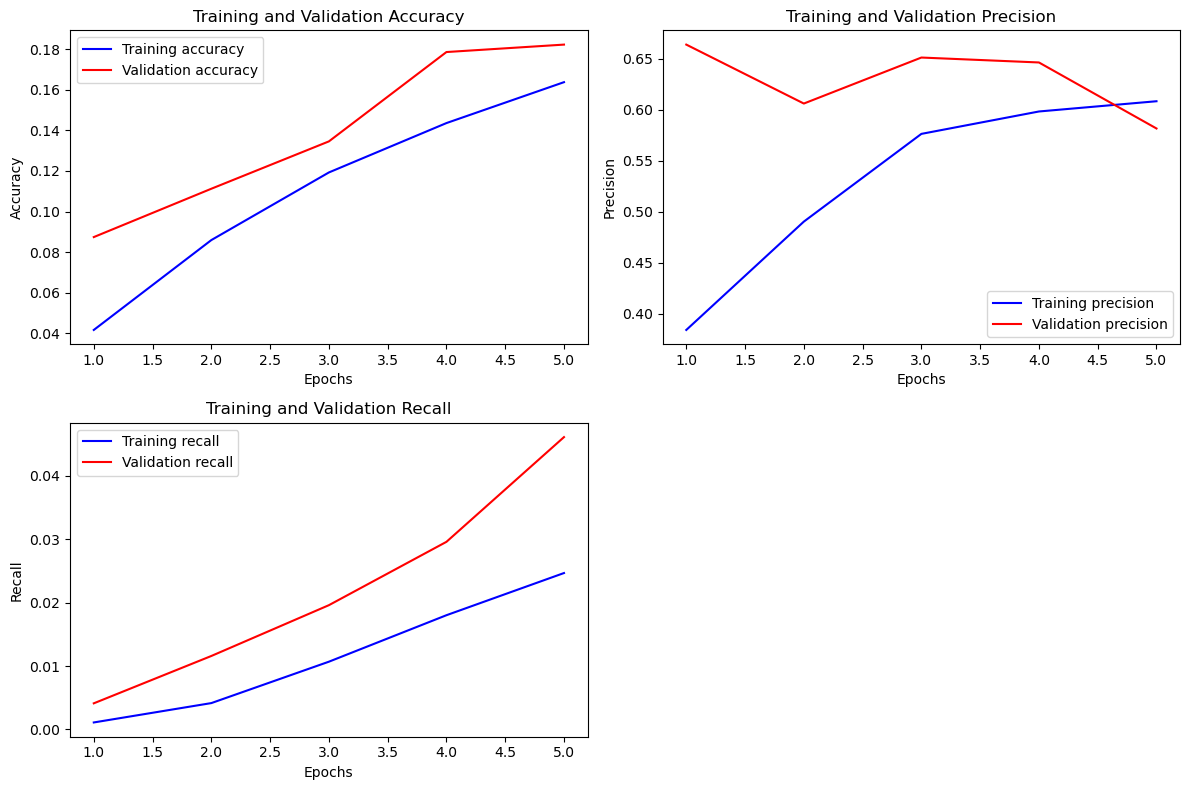

In [18]:

# Get training history
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
prec = history_1.history['precision']
val_prec = history_1.history['val_precision']
rec = history_1.history['recall']
val_rec = history_1.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.2.1 Model_1 definition ####
Variant: 3 conv layers\
optimizer: adam, gradient clipping\
learning rate: 0.001\
regularization: l2, 0.0005\
characteristics: apply regularization l2\
observation: regularization had a small down effect. could be due to chance

In [21]:
# Model1 Definition
def create_model_1(input_shape, num_classes):
    model_1 = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model_1

In [22]:
# Create model
model_1 = create_model_1(input_shape, num_classes)

# Compile model
model_1.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model_1.summary()

# Train
history_1_2 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,125 (598.14 KB)

 Trainable params: 152,677 (596.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 189s 73ms/step - accuracy: 0.0270 - loss: 4.6885 - precision: 0.2621 - recall: 4.4433e-04 - val_accuracy: 0.0659 - val_loss: 4.2936 - val_precision: 0.7463 - val_recall: 0.0025
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 189s 74ms/step - accuracy: 0.0721 - loss: 4.2421 - precision: 0.4331 - recall: 0.0024 - val_accuracy: 0.0970 - val_loss: 4.0459 - val_precision: 0.5556 - val_recall: 0.0050
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 189s 75ms/step - accuracy: 0.1015 - loss: 4.0447 - precision: 0.5128 - recall: 0.0065 - val_accuracy: 0.0999 - val_loss: 4.0813 - val_precision: 0.4529 - val_recall: 0.0179
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 186s 74ms/step - accuracy: 0.1222 - loss: 3.9118 - precision: 0.5707 - recall: 0.0127 - val_accuracy: 0.1325 - val_loss: 3.9830 - val_precision: 0.6722 - val_recall: 0.0160
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 188s 74ms/step - accuracy: 0.1449 - loss: 3.8290 - precision: 0.5784 - recall: 0.0178 - val_accurac

In [24]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.1617 - loss: 3.7532 - precision: 0.5295 - recall: 0.0453
Validation Loss: 3.720067262649536
Validation Accuracy: 0.1636633723974228
Validation Precision: 0.5296884179115295
Validation Recall: 0.04460395872592926


In [25]:
# Obtain history item keys(cuz tf gets a bit weird with naming keys)
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


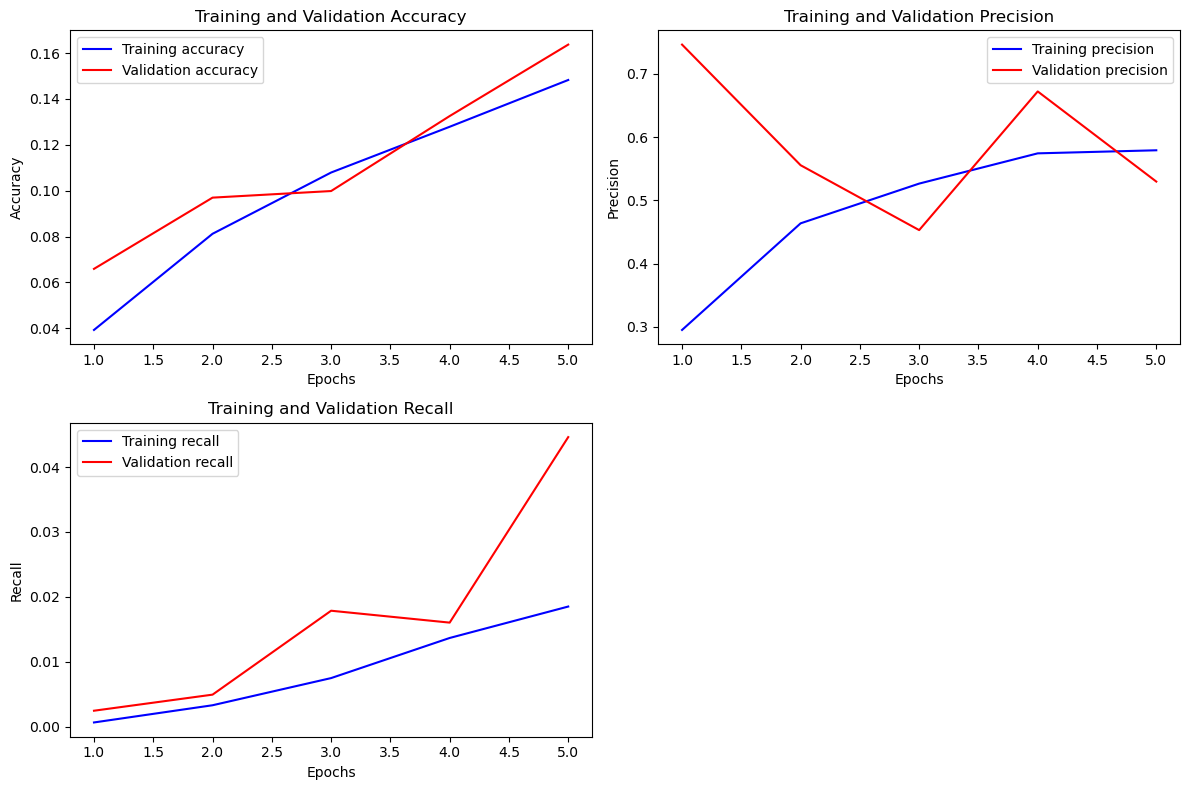

In [26]:


# Get training history
acc = history_1_2.history['accuracy']
val_acc = history_1_2.history['val_accuracy']
prec = history_1_2.history['precision']
val_prec = history_1_2.history['val_precision']
rec = history_1_2.history['recall']
val_rec = history_1_2.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.2.1 Model_1 definition ####
Variant: 3 conv layers\
optimizer: adam\
learning rate: 0.002\
regularization: l2, 0.001\
characteristics: more aggressive l2 value, slightly higher lr\
observation: higher l2 does not help, but model still learning

In [33]:
# Model1 Definition
def create_model_1(input_shape, num_classes):
    model_1 = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.001), activation='softmax')

        
    ])
    return model_1

In [34]:
# Create model
model_1 = create_model_1(input_shape, num_classes)

# Compile model
model_1.compile(
    optimizer=Adam(learning_rate=0.002, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model_1.summary()

# Train
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,125 (598.14 KB)

 Trainable params: 152,677 (596.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 190s 74ms/step - accuracy: 0.0270 - loss: 4.7711 - precision: 0.2462 - recall: 4.7838e-04 - val_accuracy: 0.0609 - val_loss: 4.3572 - val_precision: 0.6364 - val_recall: 0.0021
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 185s 73ms/step - accuracy: 0.0518 - loss: 4.4034 - precision: 0.3434 - recall: 0.0014 - val_accuracy: 0.0774 - val_loss: 4.2325 - val_precision: 0.3324 - val_recall: 0.0062
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 184s 73ms/step - accuracy: 0.0740 - loss: 4.2456 - precision: 0.4285 - recall: 0.0034 - val_accuracy: 0.0846 - val_loss: 4.2296 - val_precision: 0.7005 - val_recall: 0.0065
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 183s 72ms/step - accuracy: 0.0944 - loss: 4.1527 - precision: 0.4790 - recall: 0.0063 - val_accuracy: 0.1006 - val_loss: 4.0996 - val_precision: 0.5800 - val_recall: 0.0029
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 185s 73ms/step - accuracy: 0.1069 - loss: 4.0916 - precision: 0.5239 - recall: 0.0096 - val_accurac

In [35]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.1245 - loss: 4.0340 - precision: 0.5914 - recall: 0.0116
Validation Loss: 4.092913627624512
Validation Accuracy: 0.11811881512403488
Validation Precision: 0.5244956612586975
Validation Recall: 0.00900990143418312


In [36]:
# Obtain history item keys(cuz tf gets a bit weird with naming keys)
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


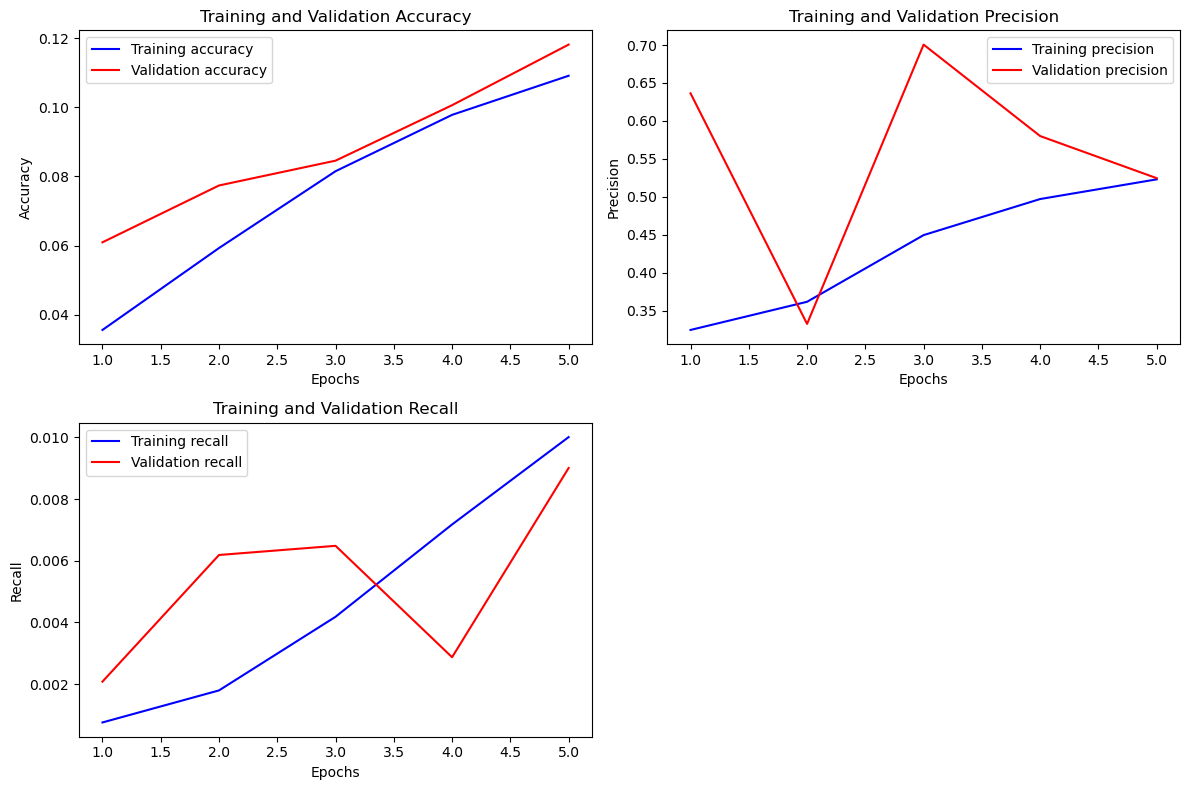

In [37]:


# Get training history
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
prec = history_1.history['precision']
val_prec = history_1.history['val_precision']
rec = history_1.history['recall']
val_rec = history_1.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.2.1 Model_1 definition ####
Variant: 3 conv layers\
optimizer: adam\
learning rate: 0.00001\
regularization: l2, 0.0004\
characteristics: way too conservative lr and regularization\
observation: steps are way too low

In [39]:
# Model1 Definition
def create_model_1(input_shape, num_classes):
    model_1 = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0004)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0004)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0004)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0004), activation='softmax')

        
    ])
    return model_1

In [41]:
# Create model
model_1 = create_model_1(input_shape, num_classes)

# Compile model
model_1.compile(
    optimizer=Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model_1.summary()

# Train
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,125 (598.14 KB)

 Trainable params: 152,677 (596.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 189s 73ms/step - accuracy: 0.0109 - loss: 4.9720 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0242 - val_loss: 4.6733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 183s 72ms/step - accuracy: 0.0130 - loss: 4.8239 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0356 - val_loss: 4.6419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 185s 73ms/step - accuracy: 0.0165 - loss: 4.7681 - precision: 0.3480 - recall: 9.2082e-06 - val_accuracy: 0.0394 - val_loss: 4.6216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 184s 73ms/step - accuracy: 0.0186 - loss: 4.7303 - precision: 0.4232 - recall: 1.1407e-04 - val_accuracy: 0.0425 - val_loss: 4.6045 - val_precision: 0.8333 - val_recall: 2.4752e-04
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 186s 73ms/step - accuracy: 0.0223 - loss: 4.7060 - 

In [42]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0387 - loss: 4.5937 - precision: 0.6169 - recall: 6.0234e-04
Validation Loss: 4.586190223693848
Validation Accuracy: 0.046683169901371
Validation Precision: 0.7857142686843872
Validation Recall: 0.0005445544375106692


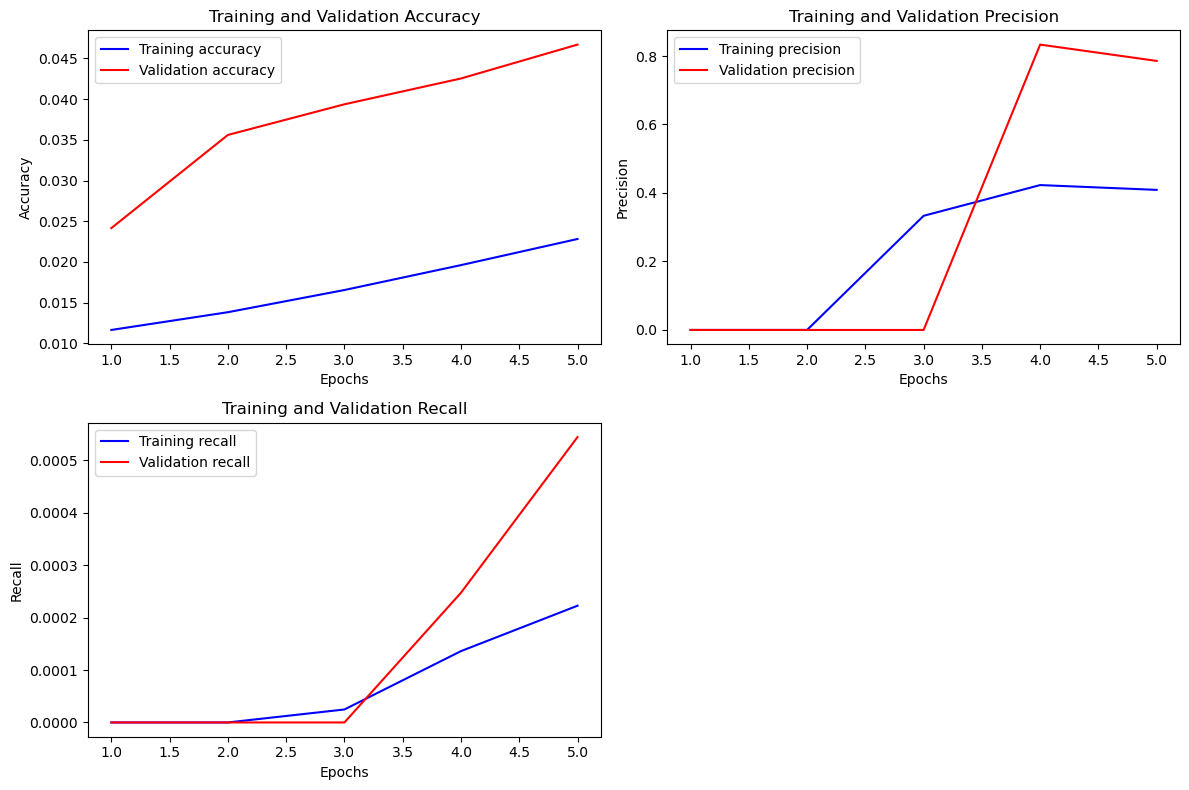

In [46]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.2.1 Model_1 definition ####
Variant: 3 conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2, 0.1\
characteristics: aggressive regularzation\
observation: high l2 absolutely worse

In [47]:
# Model1 Definition
def create_model_1(input_shape, num_classes):
    model_1 = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.1), activation='softmax')

        
    ])
    return model_1

In [48]:
# Create model
model_1 = create_model_1(input_shape, num_classes)

# Compile model
model_1.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model_1.summary()

# Train
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,125 (598.14 KB)

 Trainable params: 152,677 (596.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 192s 74ms/step - accuracy: 0.0159 - loss: 16.2791 - precision: 0.1962 - recall: 9.6848e-06 - val_accuracy: 0.0434 - val_loss: 4.6175 - val_precision: 1.0000 - val_recall: 1.4851e-04
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 187s 74ms/step - accuracy: 0.0354 - loss: 4.5746 - precision: 0.1797 - recall: 6.4101e-05 - val_accuracy: 0.0568 - val_loss: 4.4138 - val_precision: 1.0000 - val_recall: 1.4851e-04
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 187s 74ms/step - accuracy: 0.0497 - loss: 4.4286 - precision: 0.4349 - recall: 2.0778e-04 - val_accuracy: 0.0686 - val_loss: 4.3100 - val_precision: 0.7778 - val_recall: 0.0010
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 185s 73ms/step - accuracy: 0.0621 - loss: 4.3373 - precision: 0.5840 - recall: 5.0121e-04 - val_accuracy: 0.0820 - val_loss: 4.2127 - val_precision: 0.8333 - val_recall: 0.0020
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 187s 74ms/step - accuracy: 0.0703 - loss: 4.2802 - precision: 0.7592 - recall:

In [49]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0977 - loss: 4.1225 - precision: 0.6100 - recall: 0.0022
Validation Loss: 4.184814929962158
Validation Accuracy: 0.08430693298578262
Validation Precision: 0.7586206793785095
Validation Recall: 0.0032673266250640154


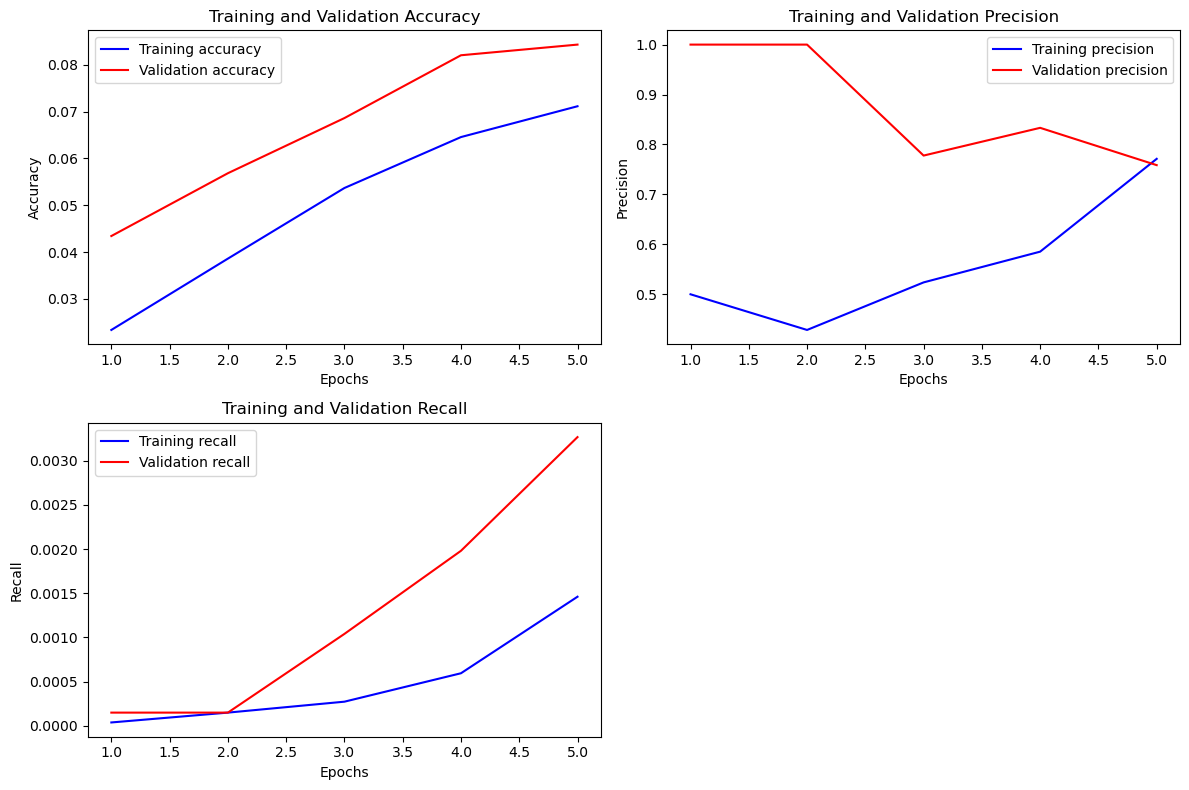

In [50]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.2.1 Model_1 definition ####
Variant: 3 conv layers\
optimizer: adam\
learning rate: 0.1\
regularization: l2, 0.0001\
characteristics: aggressive lr, stable regularization
observation: high lr worse too

In [51]:
# Model1 Definition
def create_model_1(input_shape, num_classes):
    model_1 = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0001), activation='softmax')

        
    ])
    return model_1

In [52]:
# Create model
model_1 = create_model_1(input_shape, num_classes)

# Compile model
model_1.compile(
    optimizer=Adam(learning_rate=0.1, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model_1.summary()

# Train
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,125 (598.14 KB)

 Trainable params: 152,677 (596.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 187s 73ms/step - accuracy: 0.0089 - loss: 5.4138 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.7016 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 182s 72ms/step - accuracy: 0.0089 - loss: 4.6742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 184s 73ms/step - accuracy: 0.0094 - loss: 5.3945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.8988 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 183s 72ms/step - accuracy: 0.0103 - loss: 4.9649 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 183s 72ms/step - accuracy: 0.0100 - los

In [53]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0158 - loss: 4.6504 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.654635906219482
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


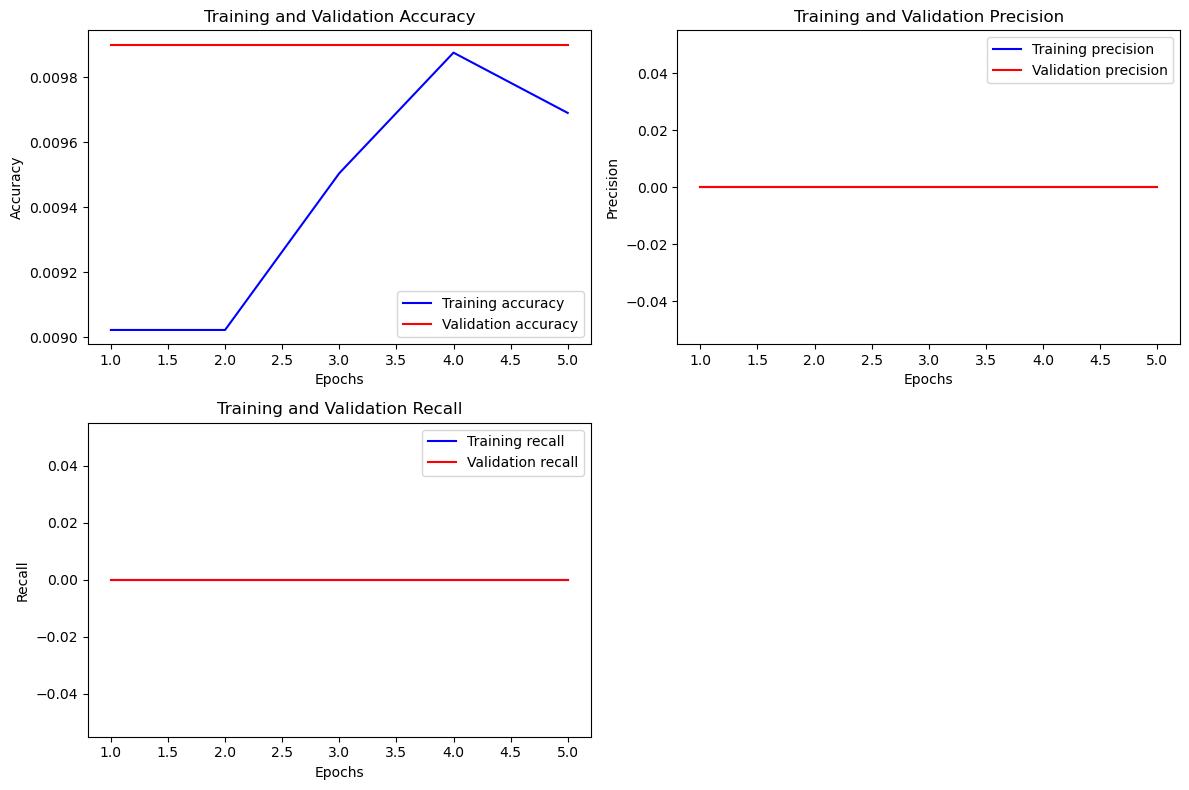

In [54]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


### 3.3 Convolutional neural network: Model_2: 5 conv layers ###
Notes: 5 conv layers

#### 3.3.1 Model_2 definition ####
Variant: conv blocks for 3 conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2, 0.0005\
characteristics: baseline model with hyprparams that make sense, steady improvements

In [71]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [72]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 299, 299, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 74, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,781 (1.33 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 318s 124ms/step - accuracy: 0.0187 - loss: 4.9392 - precision: 0.5298 - recall: 3.4849e-04 - val_accuracy: 0.0646 - val_loss: 4.5588 - val_precision: 0.9048 - val_recall: 9.4059e-04
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 309s 122ms/step - accuracy: 0.0433 - loss: 4.6294 - precision: 0.3979 - recall: 0.0012 - val_accuracy: 0.0791 - val_loss: 4.3872 - val_precision: 0.7736 - val_recall: 0.0020
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 304s 120ms/step - accuracy: 0.0584 - loss: 4.4570 - precision: 0.4035 - recall: 0.0018 - val_accuracy: 0.1001 - val_loss: 4.1957 - val_precision: 0.7750 - val_recall: 0.0046
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 304s 120ms/step - accuracy: 0.0745 - loss: 4.3119 - precision: 0.4883 - recall: 0.0031 - val_accuracy: 0.1145 - val_loss: 4.0883 - val_precision: 0.7979 - val_recall: 0.0076
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 306s 121ms/step - accuracy: 0.0910 - loss: 4.1789 - precision: 0.5833 - recall: 0.0051 - va

In [73]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model_1.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0158 - loss: 4.6504 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.654635906219482
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


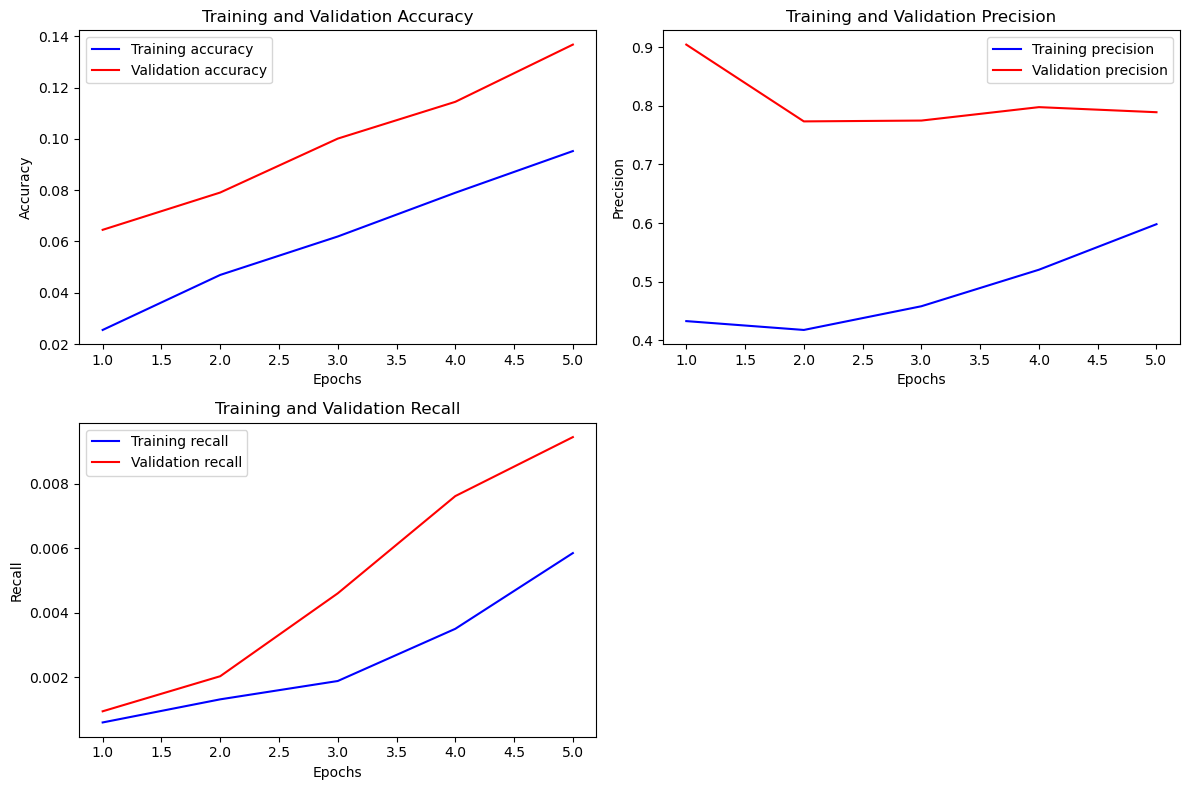

In [74]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.3.1 Model_2 definition ####
Variant: conv blocks for 3 conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2, 0.0005\
characteristics: more aggressive lr

In [75]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [76]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)              │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 299, 299, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 74, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,781 (1.33 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 309s 121ms/step - accuracy: 0.0245 - loss: 4.7825 - precision: 0.3023 - recall: 6.5817e-04 - val_accuracy: 0.0684 - val_loss: 4.3061 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.0574 - loss: 4.3345 - precision: 0.3767 - recall: 9.6980e-04 - val_accuracy: 0.0966 - val_loss: 4.0531 - val_precision: 0.5602 - val_recall: 0.0046
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.0942 - loss: 4.0987 - precision: 0.4859 - recall: 0.0043 - val_accuracy: 0.0969 - val_loss: 4.0590 - val_precision: 0.5978 - val_recall: 0.0082
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.1308 - loss: 3.8947 - precision: 0.5579 - recall: 0.0126 - val_accuracy: 0.1483 - val_loss: 3.7861 - val_precision: 0.6608 - val_recall: 0.0258
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 304s 120ms/step - accuracy: 0.1621 - loss: 3.7508 - precision: 0.6066 - recall: 0.0

In [78]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.1573 - loss: 3.8197 - precision: 0.6501 - recall: 0.0323
Validation Loss: 3.788753032684326
Validation Accuracy: 0.16757425665855408
Validation Precision: 0.6805697083473206
Validation Recall: 0.03311881050467491


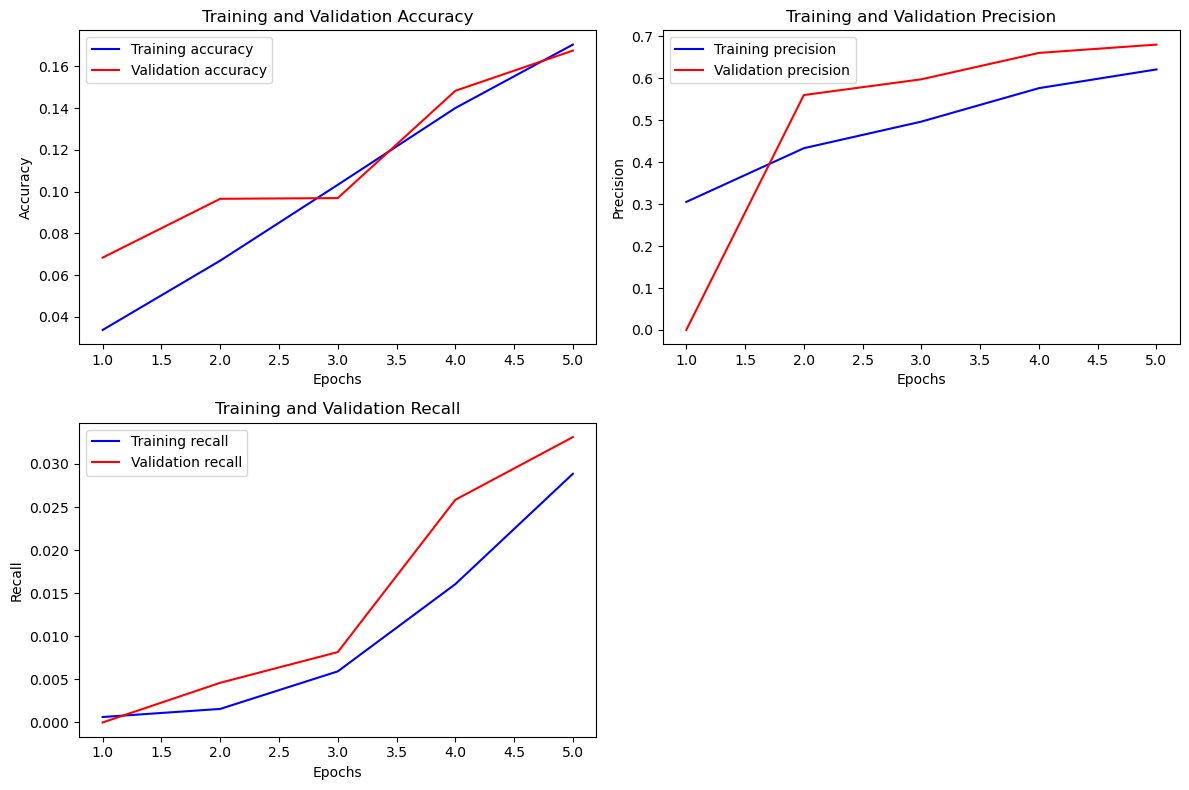

In [79]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.3.1 Model_2 definition ####
Variant: conv blocks for 3 conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2, 0.0003\
characteristics: more conservative lr, slightly less regularization

In [80]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0003), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0003), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0003), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0003), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0003), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0003), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0003), activation='softmax')

        
    ])
    return model

In [81]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 299, 299, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 74, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,781 (1.33 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0172 - loss: 4.8665 - precision: 0.2657 - recall: 2.2696e-04

2025-04-28 04:38:10.273101: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 34343168 bytes after encountering the first element of size 34343168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 309s 121ms/step - accuracy: 0.0172 - loss: 4.8665 - precision: 0.2657 - recall: 2.2705e-04 - val_accuracy: 0.0560 - val_loss: 4.5144 - val_precision: 0.5714 - val_recall: 0.0012
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.0385 - loss: 4.5741 - precision: 0.3452 - recall: 8.5547e-04 - val_accuracy: 0.0755 - val_loss: 4.3292 - val_precision: 0.7692 - val_recall: 9.9010e-04
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 304s 120ms/step - accuracy: 0.0588 - loss: 4.3857 - precision: 0.3651 - recall: 0.0012 - val_accuracy: 0.0994 - val_loss: 4.1599 - val_precision: 0.8250 - val_recall: 0.0016
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 304s 120ms/step - accuracy: 0.0749 - loss: 4.2515 - precision: 0.4957 - recall: 0.0029 - val_accuracy: 0.1114 - val_loss: 4.0395 - val_precision: 0.8765 - val_recall: 0.0035
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 305s 121ms/step - accuracy: 0.0934 - loss: 4.1185 - precision: 0.6088 - recall: 0.0056 - val_accu

In [82]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.1436 - loss: 3.8249 - precision: 0.7463 - recall: 0.0091
Validation Loss: 3.853926658630371
Validation Accuracy: 0.14178217947483063
Validation Precision: 0.8227847814559937
Validation Recall: 0.009653464891016483


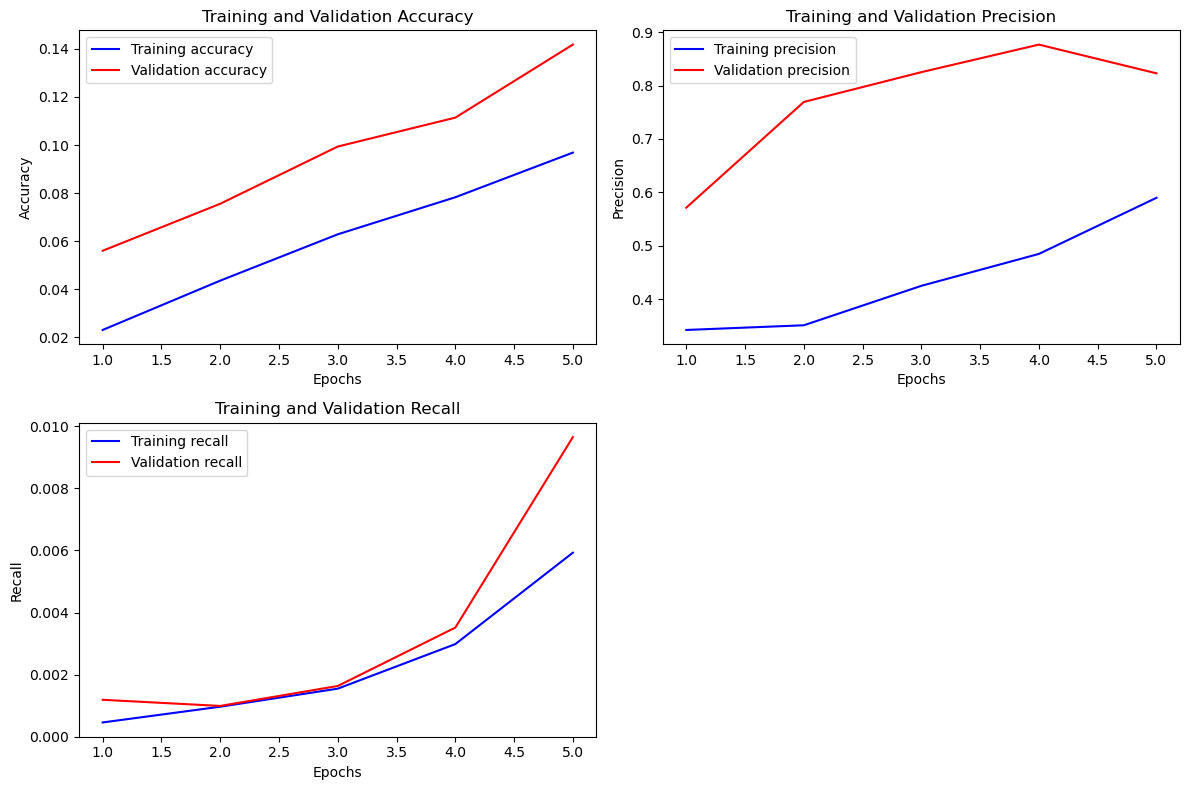

In [83]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.3.1 Model_2 definition ####
Variant: conv blocks for 3 conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2, 0.0005\
characteristics: aggressive lr

In [85]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [86]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 299, 299, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 74, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,781 (1.33 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 309s 120ms/step - accuracy: 0.0276 - loss: 4.7419 - precision: 0.2874 - recall: 6.0111e-04 - val_accuracy: 0.0700 - val_loss: 4.2433 - val_precision: 0.4444 - val_recall: 5.9406e-04
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0710 - loss: 4.2420 - precision: 0.3834 - recall: 0.0019

2025-04-28 05:12:07.647266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 34343168 bytes after encountering the first element of size 34343168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 305s 121ms/step - accuracy: 0.0710 - loss: 4.2420 - precision: 0.3834 - recall: 0.0019 - val_accuracy: 0.0862 - val_loss: 4.2278 - val_precision: 0.1817 - val_recall: 0.0096
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.1136 - loss: 3.9862 - precision: 0.5616 - recall: 0.0101 - val_accuracy: 0.1082 - val_loss: 4.2381 - val_precision: 0.2790 - val_recall: 0.0260
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.1517 - loss: 3.8055 - precision: 0.6100 - recall: 0.0226 - val_accuracy: 0.1428 - val_loss: 3.9223 - val_precision: 0.5299 - val_recall: 0.0404
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 302s 120ms/step - accuracy: 0.1827 - loss: 3.6554 - precision: 0.6116 - recall: 0.0333 - val_accuracy: 0.2128 - val_loss: 3.4782 - val_precision: 0.7069 - val_recall: 0.0572


In [87]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.1982 - loss: 3.5210 - precision: 0.6516 - recall: 0.0471
Validation Loss: 3.4781949520111084
Validation Accuracy: 0.21282178163528442
Validation Precision: 0.7068543434143066
Validation Recall: 0.05717821791768074


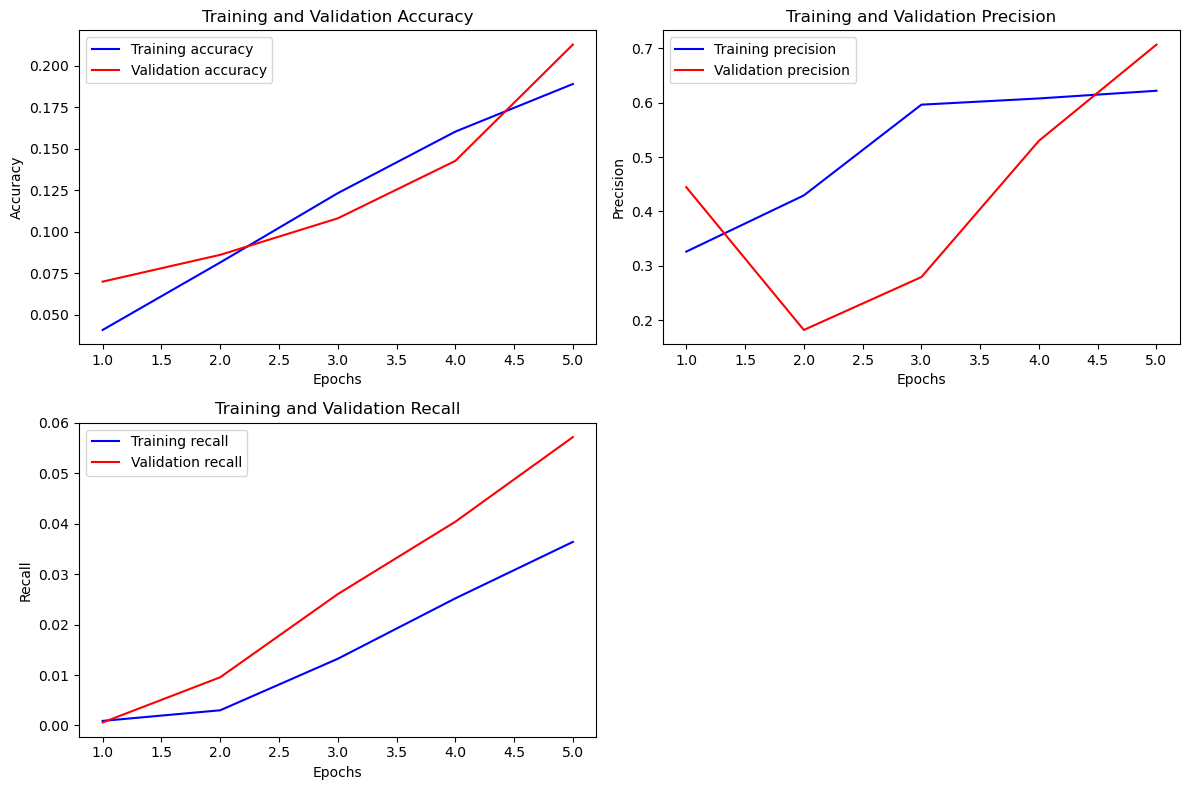

In [88]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.3.1 Model_2 definition ####
Variant: conv blocks for 3 conv layers\
optimizer: adam\
learning rate: 0.005\
regularization: l2, 0.0005\
characteristics: last one got highest yet, feels like underfit. so higher lr.

In [89]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [90]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.005, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 299, 299, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 74, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,781 (1.33 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 308s 120ms/step - accuracy: 0.0144 - loss: 4.8411 - precision: 0.2202 - recall: 6.4507e-05 - val_accuracy: 0.0173 - val_loss: 4.6494 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.0192 - loss: 4.6557 - precision: 0.2953 - recall: 7.3288e-04 - val_accuracy: 0.0173 - val_loss: 4.6548 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 303s 120ms/step - accuracy: 0.0218 - loss: 4.5788 - precision: 0.2395 - recall: 2.9158e-04 - val_accuracy: 0.0342 - val_loss: 4.4781 - val_precision: 0.4370 - val_recall: 0.0029
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 344s 136ms/step - accuracy: 0.0270 - loss: 4.5219 - precision: 0.3713 - recall: 6.5454e-04 - val_accuracy: 0.0340 - val_loss: 4.4466 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 295s 117ms/step - accuracy: 0.0278 - loss: 4.4962 - precisi

In [91]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.0418 - loss: 4.3961 - precision: 0.4723 - recall: 0.0016
Validation Loss: 4.43758487701416
Validation Accuracy: 0.033514849841594696
Validation Precision: 0.460317462682724
Validation Recall: 0.0014356435276567936


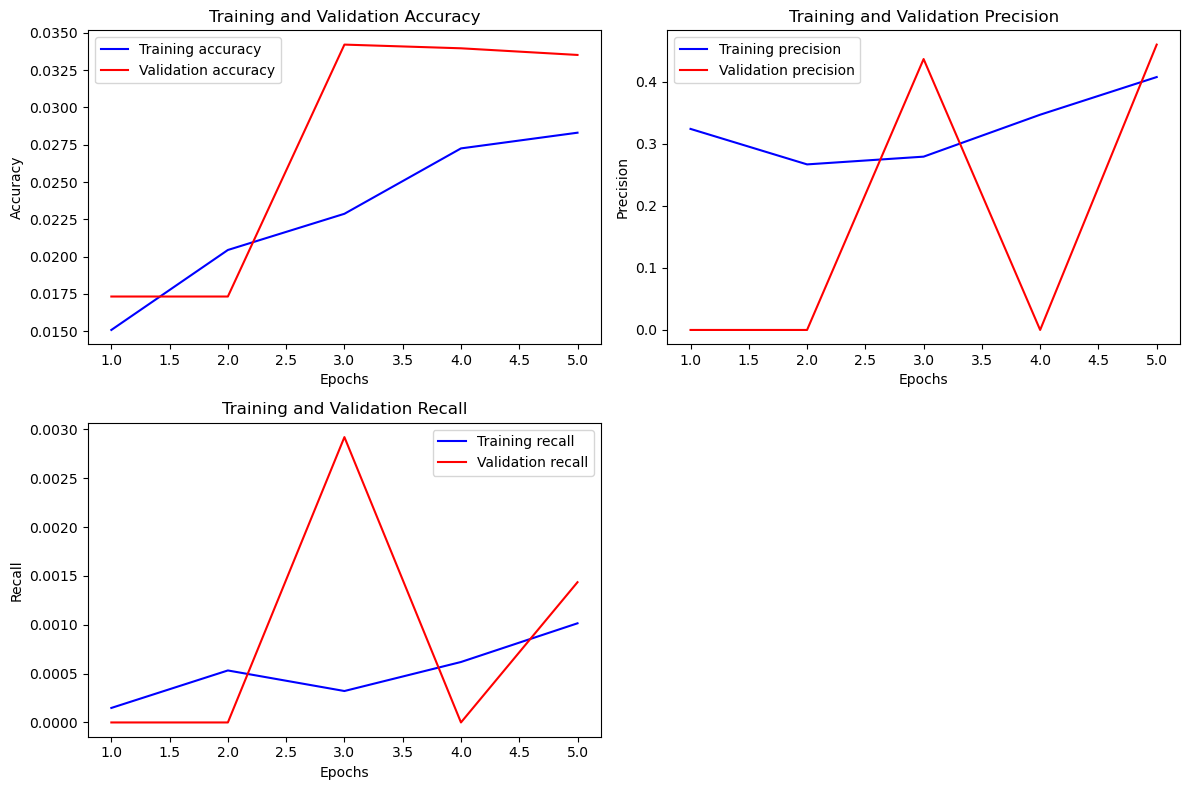

In [92]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.3.1 Model_2 definition ####
Variant: conv blocks for 3 conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2, 0.05\
characteristics: aggressive regularization

In [93]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.05), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.05), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.05), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.05), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.05), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.05), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.05), activation='softmax')

        
    ])
    return model

In [94]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 299, 299, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 149, 149, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 74, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,781 (1.33 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 305s 119ms/step - accuracy: 0.0185 - loss: 16.4050 - precision: 0.2927 - recall: 1.9894e-04 - val_accuracy: 0.0508 - val_loss: 4.7733 - val_precision: 1.0000 - val_recall: 4.9505e-05
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 299s 118ms/step - accuracy: 0.0466 - loss: 4.6490 - precision: 0.2950 - recall: 1.8949e-04 - val_accuracy: 0.0669 - val_loss: 4.3913 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 652s 258ms/step - accuracy: 0.0624 - loss: 4.3775 - precision: 0.5305 - recall: 4.0489e-04 - val_accuracy: 0.0806 - val_loss: 4.2272 - val_precision: 0.8154 - val_recall: 0.0026
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 345s 136ms/step - accuracy: 0.0829 - loss: 4.2195 - precision: 0.6576 - recall: 0.0026 - val_accuracy: 0.0965 - val_loss: 4.0908 - val_precision: 0.6852 - val_recall: 0.0055
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 304s 120ms/step - accuracy: 0.0998 - loss: 4.1058 - precision: 0.6352 - re

In [95]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.1201 - loss: 3.9725 - precision: 0.6969 - recall: 0.0181
Validation Loss: 4.037822723388672
Validation Accuracy: 0.11054455488920212
Validation Precision: 0.6761658191680908
Validation Recall: 0.01292079221457243


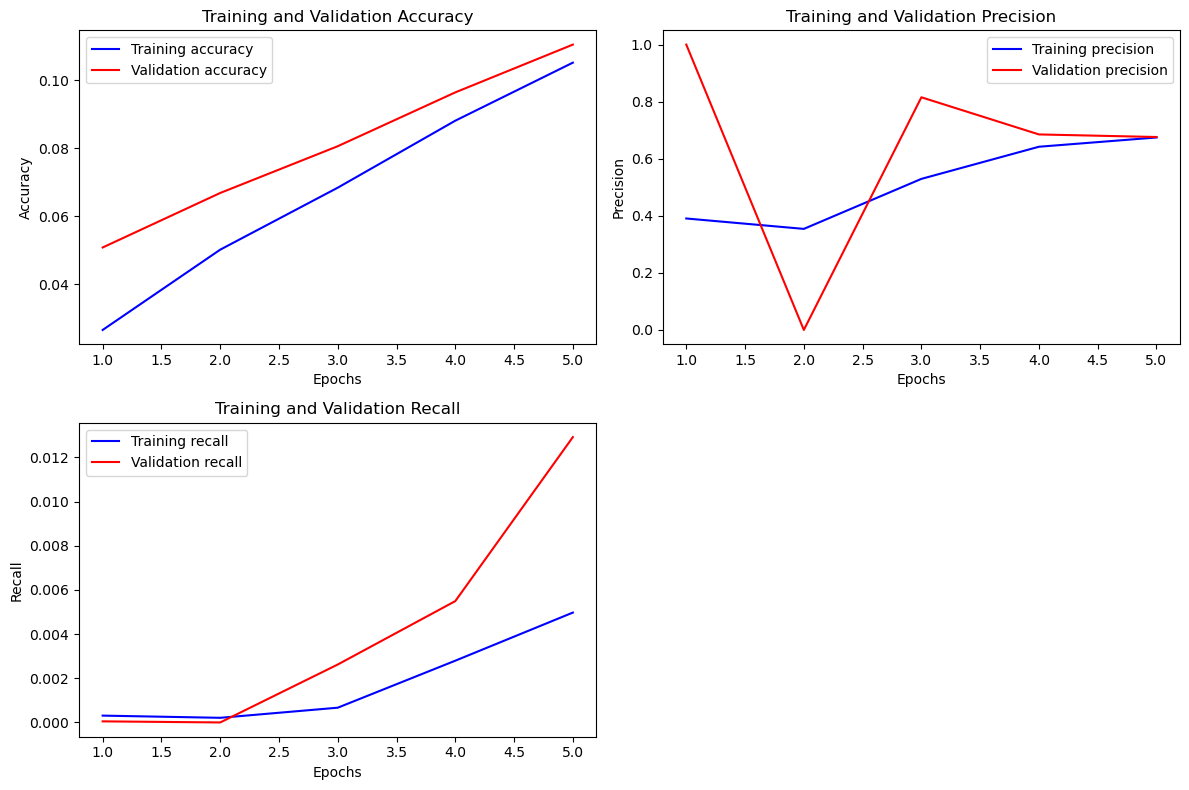

In [96]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


### 3.4 Convolutional neural network: Model_3: 5 conv layers ###
Notes: 5 conv layers

#### 3.4.1 Model_3 definition ####
Variant: conv blocks for 5 conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2, 0.0005\
characteristics: baseline model

In [99]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv4
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv5
        layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [100]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_120 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_22     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,829 (6.60 MB)

 Trainable params: 1,727,845 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0186 - loss: 5.2156 - precision: 0.2097 - recall: 5.6571e-04

2025-04-28 06:51:06.267810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_305', 188 bytes spill stores, 188 bytes spill loads

2025-04-28 06:51:27.170369: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_305', 96 bytes spill stores, 96 bytes spill loads



2525/2525 ━━━━━━━━━━━━━━━━━━━━ 241s 94ms/step - accuracy: 0.0186 - loss: 5.2156 - precision: 0.2098 - recall: 5.6588e-04 - val_accuracy: 0.0630 - val_loss: 4.7204 - val_precision: 0.7234 - val_recall: 0.0017
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 206s 81ms/step - accuracy: 0.0427 - loss: 4.7887 - precision: 0.3898 - recall: 0.0019 - val_accuracy: 0.0959 - val_loss: 4.4021 - val_precision: 0.7023 - val_recall: 0.0046
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 645s 255ms/step - accuracy: 0.0709 - loss: 4.5012 - precision: 0.4915 - recall: 0.0050 - val_accuracy: 0.1243 - val_loss: 4.1438 - val_precision: 0.7216 - val_recall: 0.0098
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 199s 79ms/step - accuracy: 0.1064 - loss: 4.2181 - precision: 0.5733 - recall: 0.0129 - val_accuracy: 0.1866 - val_loss: 3.7526 - val_precision: 0.7433 - val_recall: 0.0331
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 644s 255ms/step - accuracy: 0.1447 - loss: 3.9596 - precision: 0.6210 - recall: 0.0248 - val_accuracy: 0.219

In [101]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.2170 - loss: 3.5406 - precision: 0.6378 - recall: 0.0594
Validation Loss: 3.5338196754455566
Validation Accuracy: 0.21965347230434418
Validation Precision: 0.6668472290039062
Validation Recall: 0.06094059348106384


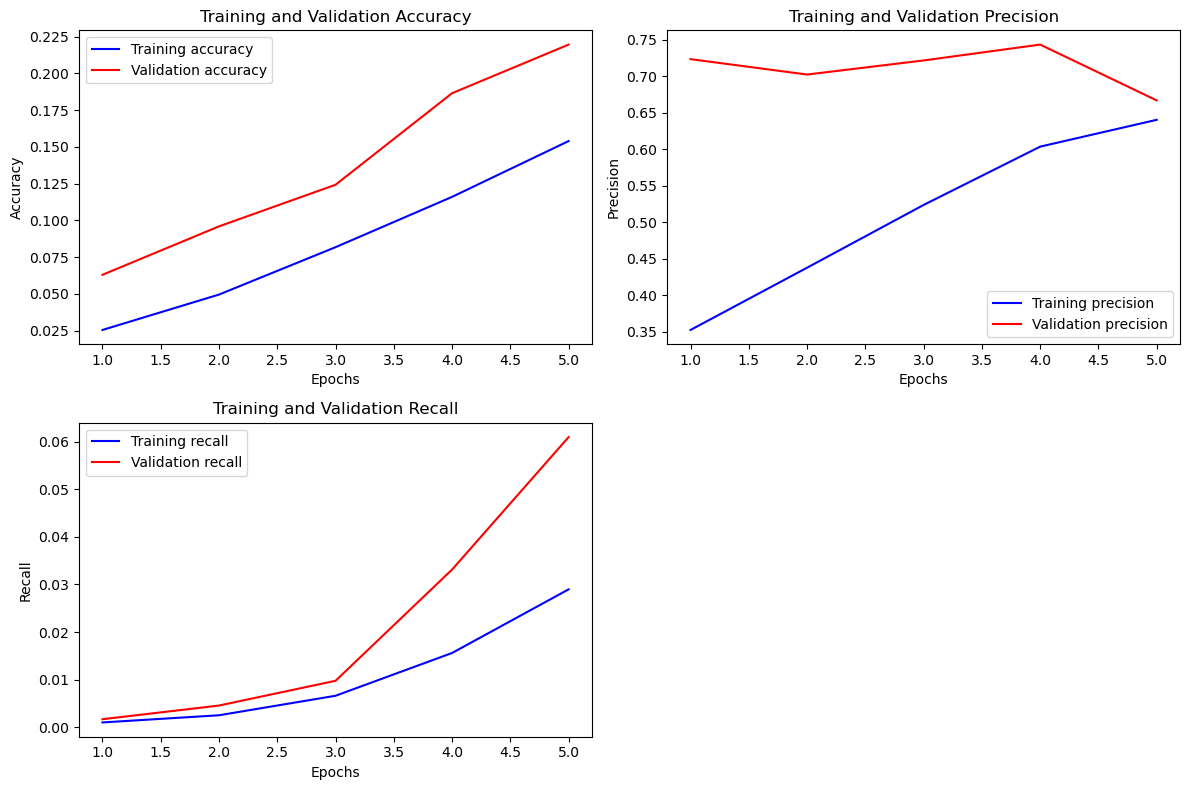

In [102]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.4.1 Model_3 definition ####
Variant: conv blocks for 5 conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2, 0.0005\
characteristics: more aggressive lr

In [103]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv4
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv5
        layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [104]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_125 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,829 (6.60 MB)

 Trainable params: 1,727,845 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 210s 81ms/step - accuracy: 0.0205 - loss: 4.9877 - precision: 0.1745 - recall: 2.7252e-04 - val_accuracy: 0.0550 - val_loss: 4.4126 - val_precision: 0.4342 - val_recall: 0.0016
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0466 - loss: 4.4588 - precision: 0.3901 - recall: 0.0012

2025-04-28 14:18:35.326180: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 34343168 bytes after encountering the first element of size 34343168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 205s 81ms/step - accuracy: 0.0466 - loss: 4.4588 - precision: 0.3901 - recall: 0.0012 - val_accuracy: 0.0804 - val_loss: 4.2684 - val_precision: 0.4895 - val_recall: 0.0035
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 647s 256ms/step - accuracy: 0.0754 - loss: 4.3008 - precision: 0.4628 - recall: 0.0050 - val_accuracy: 0.1001 - val_loss: 4.2011 - val_precision: 0.3904 - val_recall: 0.0204
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 645s 255ms/step - accuracy: 0.1096 - loss: 4.1332 - precision: 0.5736 - recall: 0.0134 - val_accuracy: 0.1003 - val_loss: 4.4400 - val_precision: 0.3898 - val_recall: 0.0260
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 205s 81ms/step - accuracy: 0.1444 - loss: 3.9661 - precision: 0.5967 - recall: 0.0249 - val_accuracy: 0.1880 - val_loss: 3.7160 - val_precision: 0.6396 - val_recall: 0.0464


In [105]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.1747 - loss: 3.7305 - precision: 0.6068 - recall: 0.0444
Validation Loss: 3.71602725982666
Validation Accuracy: 0.188019797205925
Validation Precision: 0.6395904421806335
Validation Recall: 0.04638613760471344


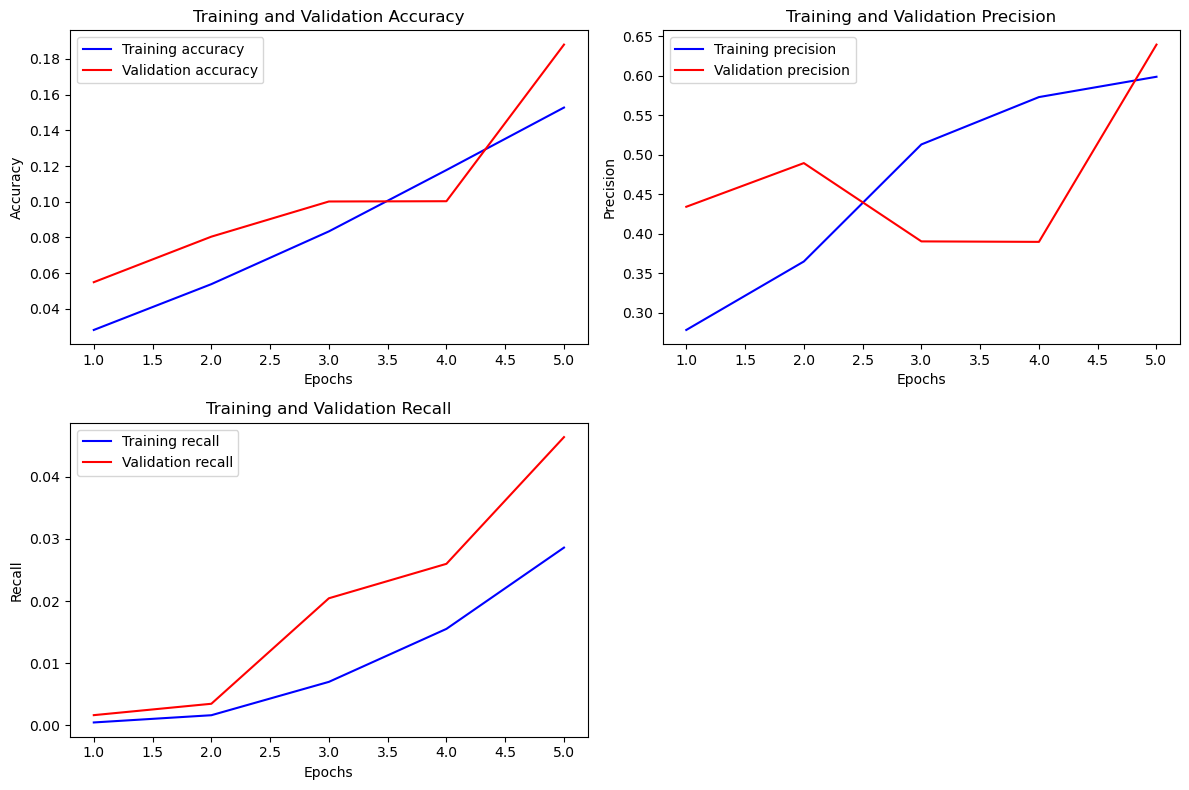

In [106]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.4.1 Model_3 definition ####
Variant: conv blocks for 5 conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2, 0.00001\
characteristics: smaller regularization

In [111]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.00001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.00001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.00001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv4
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(.00001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv5
        layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(.00001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.00001), activation='softmax')

        
    ])
    return model

In [112]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_25     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,829 (6.60 MB)

 Trainable params: 1,727,845 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 342s 134ms/step - accuracy: 0.0210 - loss: 4.8403 - precision: 0.2477 - recall: 7.1802e-04 - val_accuracy: 0.0554 - val_loss: 4.3970 - val_precision: 0.6000 - val_recall: 0.0025
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 337s 133ms/step - accuracy: 0.0422 - loss: 4.4556 - precision: 0.3455 - recall: 0.0017 - val_accuracy: 0.0876 - val_loss: 4.1270 - val_precision: 0.8105 - val_recall: 0.0038
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 207s 82ms/step - accuracy: 0.0705 - loss: 4.2311 - precision: 0.4572 - recall: 0.0047 - val_accuracy: 0.1121 - val_loss: 3.9393 - val_precision: 0.7289 - val_recall: 0.0099
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 201s 79ms/step - accuracy: 0.1000 - loss: 3.9947 - precision: 0.5238 - recall: 0.0107 - val_accuracy: 0.1770 - val_loss: 3.5905 - val_precision: 0.7282 - val_recall: 0.0240
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 645s 255ms/step - accuracy: 0.1361 - loss: 3.7832 - precision: 0.6193 - recall: 0.0227 - val_accu

In [113]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.1978 - loss: 3.4415 - precision: 0.7010 - recall: 0.0364
Validation Loss: 3.410142660140991
Validation Accuracy: 0.20717822015285492
Validation Precision: 0.7279214859008789
Validation Recall: 0.04039603844285011


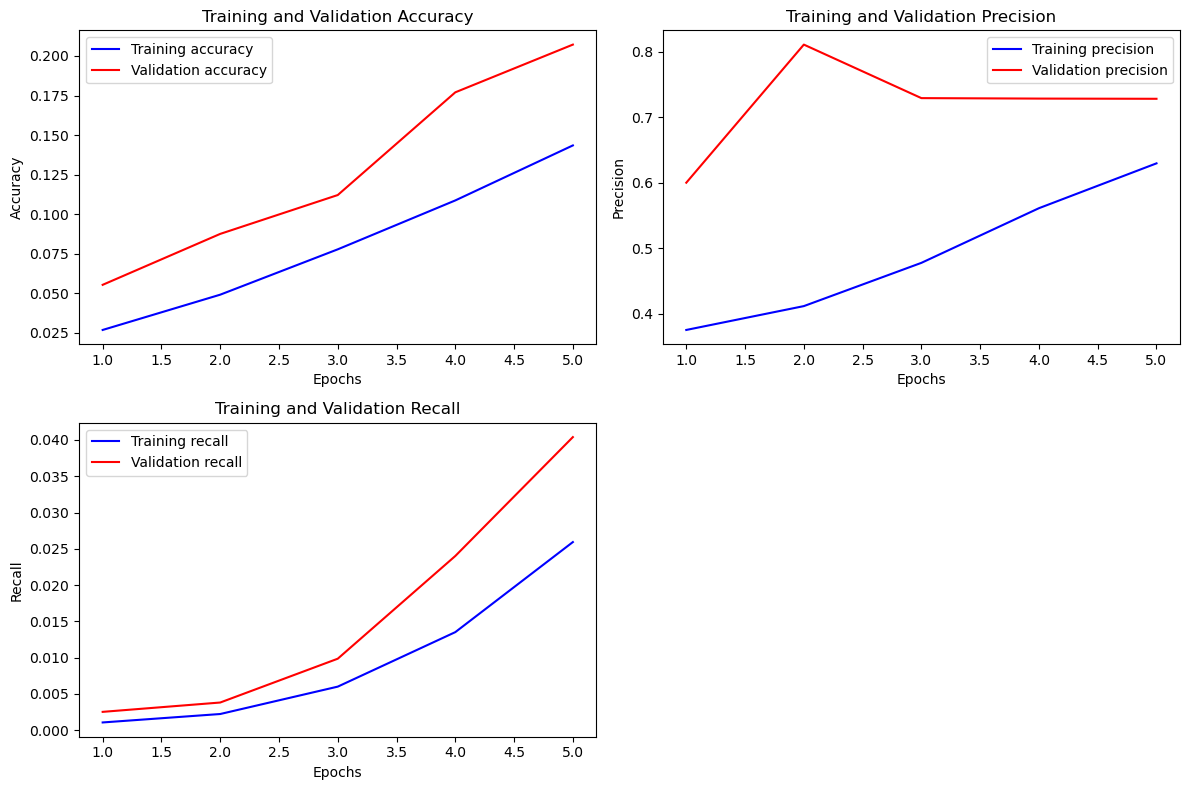

In [114]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.4.1 Model_3 definition ####
Variant: conv blocks for 5 conv layers\
optimizer: adam\
learning rate: 0.00001\
regularization: l2, 0.0005\
characteristics: conservative learning rate

In [107]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv4
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv5
        layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(.0005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0005), activation='softmax')

        
    ])
    return model

In [108]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_130 (Conv2D)             │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,829 (6.60 MB)

 Trainable params: 1,727,845 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/5


2025-04-28 14:57:15.657690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 34343040 bytes after encountering the first element of size 34343040 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 213s 83ms/step - accuracy: 0.0132 - loss: 5.5482 - precision: 0.0069 - recall: 2.5303e-05 - val_accuracy: 0.0382 - val_loss: 4.9269 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 206s 81ms/step - accuracy: 0.0186 - loss: 5.0659 - precision: 0.3561 - recall: 1.3175e-04 - val_accuracy: 0.0461 - val_loss: 4.8995 - val_precision: 0.7097 - val_recall: 0.0011
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 645s 255ms/step - accuracy: 0.0246 - loss: 4.9805 - precision: 0.5200 - recall: 9.9107e-04 - val_accuracy: 0.0534 - val_loss: 4.8548 - val_precision: 0.7556 - val_recall: 0.0017
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 199s 79ms/step - accuracy: 0.0288 - loss: 4.9370 - precision: 0.4332 - recall: 0.0011 - val_accuracy: 0.0611 - val_loss: 4.8030 - val_precision: 0.6559 - val_recall: 0.0030
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 200s 79ms/step - accuracy: 0.0353 - loss: 4.8899 - precision: 0.4477 - recall: 0.0018 - val_

In [109]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0681 - loss: 4.7582 - precision: 0.2402 - recall: 9.7637e-04
Validation Loss: 4.750464916229248
Validation Accuracy: 0.06861386448144913
Validation Precision: 0.6315789222717285
Validation Recall: 0.002970297122374177


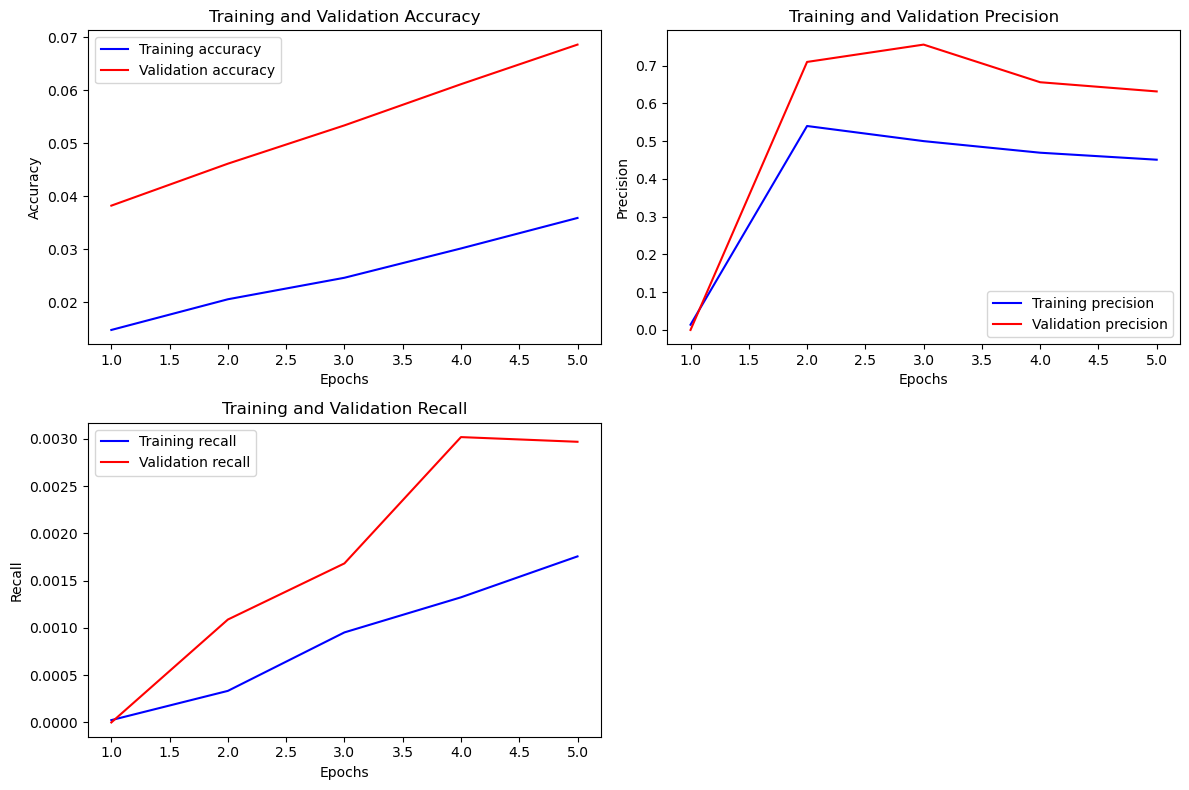

In [110]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.4.1 Model_3 definition ####
Variant: conv blocks for 5 conv layers\
optimizer: adam\
learning rate: 0.01\
regularization: l2, 0.05\
characteristics: even more aggressive learning rate and regularization

In [11]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv4
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(.005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv5
        layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(.005), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.005), activation='softmax')

        
    ])
    return model

In [12]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.01, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,829 (6.60 MB)

 Trainable params: 1,727,845 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/5


I0000 00:00:1745883418.027314  190305 service.cc:152] XLA service 0x728f60017640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745883418.027329  190305 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-04-28 19:36:58.142153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745883418.954994  190305 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-28 19:36:59.812065: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3262', 364 bytes spill stores, 364 bytes spill loads

2025-04-28 19:36:59.943150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

   2/2525 ━━━━━━━━━━━━━━━━━━━━ 3:35 85ms/step - accuracy: 0.0000e+00 - loss: 9.7999 - precision: 0.0000e+00 - recall: 0.0000e+00 

I0000 00:00:1745883425.310375  190305 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0101 - loss: 5.8622 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-04-28 19:40:26.721259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_317', 188 bytes spill stores, 188 bytes spill loads

2025-04-28 19:40:49.421914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_317', 96 bytes spill stores, 96 bytes spill loads



2525/2525 ━━━━━━━━━━━━━━━━━━━━ 234s 89ms/step - accuracy: 0.0101 - loss: 5.8618 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6194 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 211s 83ms/step - accuracy: 0.0096 - loss: 4.6203 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6192 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 229s 91ms/step - accuracy: 0.0093 - loss: 4.6203 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6193 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 236s 93ms/step - accuracy: 0.0103 - loss: 4.6202 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6194 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 222s 88ms/step - accuracy: 0.0098 - loss: 4.6204 

In [13]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0040 - loss: 4.6162 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.619308948516846
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


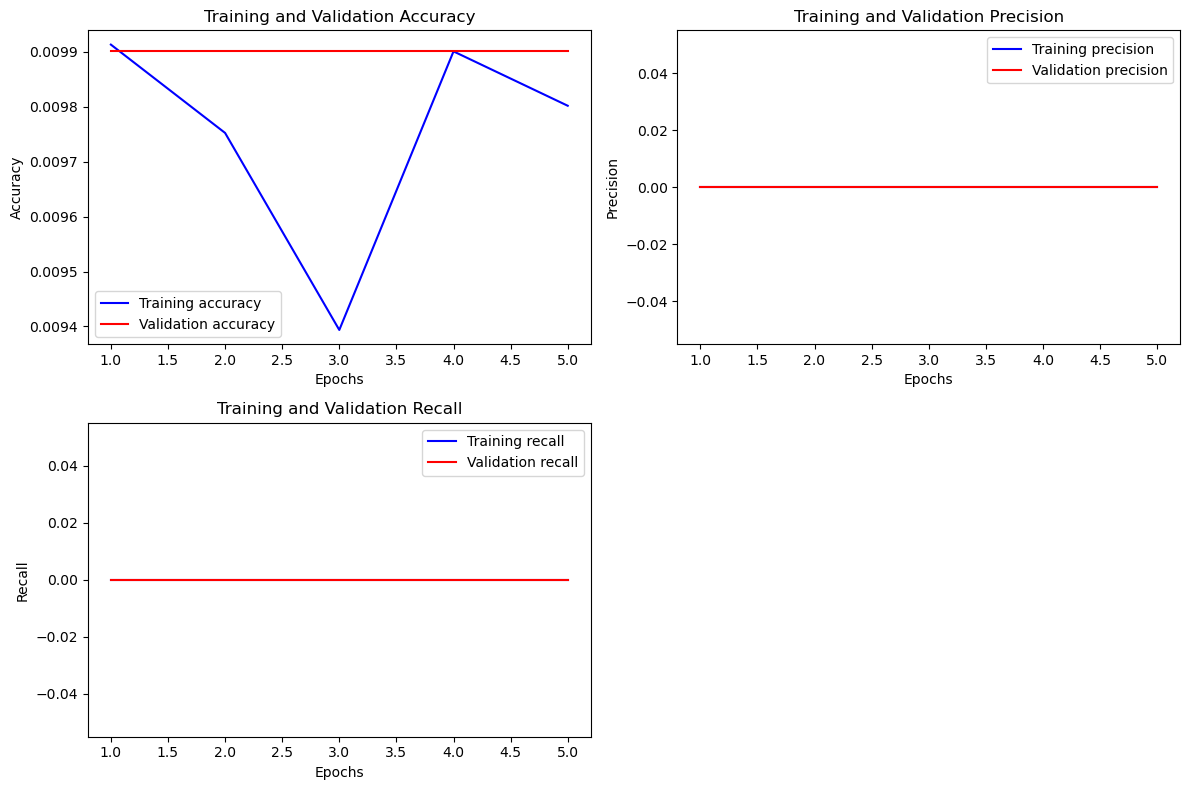

In [14]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 3.4.1 Model_3 definition ####
Variant: conv blocks for 5 conv layers\
optimizer: adam\
learning rate: 0.000125\
regularization: l2, 0.0008\
characteristics: last model, kind of random hyprparams in a good ballpark

In [15]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv1
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0008), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv2
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0008), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv3
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0008), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv4
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(.0008), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv5
        layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(.0008), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, kernel_regularizer=l2(.0008), activation='softmax')

        
    ])
    return model

In [16]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.000125, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,829 (6.60 MB)

 Trainable params: 1,727,845 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 211s 82ms/step - accuracy: 0.0196 - loss: 5.4173 - precision: 0.1958 - recall: 4.6511e-04 - val_accuracy: 0.0563 - val_loss: 4.8747 - val_precision: 0.7294 - val_recall: 0.0031
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 234s 93ms/step - accuracy: 0.0468 - loss: 4.8839 - precision: 0.3908 - recall: 0.0024 - val_accuracy: 0.1052 - val_loss: 4.4299 - val_precision: 0.7957 - val_recall: 0.0037
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 218s 86ms/step - accuracy: 0.0853 - loss: 4.4716 - precision: 0.4721 - recall: 0.0063 - val_accuracy: 0.1527 - val_loss: 3.9759 - val_precision: 0.7065 - val_recall: 0.0199
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 209s 83ms/step - accuracy: 0.1292 - loss: 4.0917 - precision: 0.5983 - recall: 0.0197 - val_accuracy: 0.1852 - val_loss: 3.7429 - val_precision: 0.6495 - val_recall: 0.0462
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 209s 82ms/step - accuracy: 0.1803 - loss: 3.7727 - precision: 0.6460 - recall: 0.0395 - val_accurac

In [17]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.2616 - loss: 3.3589 - precision: 0.7326 - recall: 0.0706
Validation Loss: 3.333627462387085
Validation Accuracy: 0.26940593123435974
Validation Precision: 0.7691903114318848
Validation Recall: 0.07242574542760849


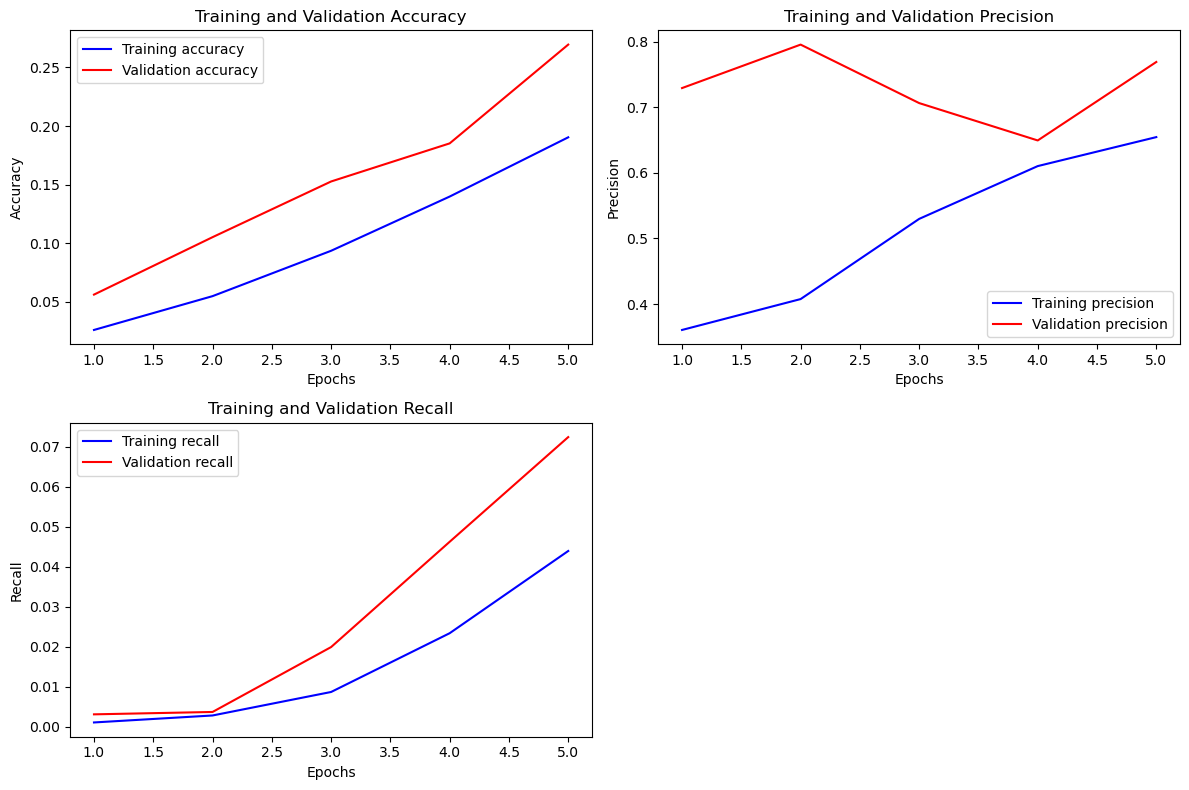

In [18]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


## 4. Supervised Analysis: NN ##

### 4.1 Neural Network: Model_4: flatten the input

#### 4.1.1 Model_4 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: none\
characteristics: testing a baseline model. Input is huge, unlikely any NN will learn at all.

In [19]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Flatten(),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [20]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    68,660,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,707,941 (262.10 MB)

 Trainable params: 68,707,941 (262.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2524/2525 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0096 - loss: 5.5583 - precision: 0.0136 - recall: 7.0091e-04

2025-04-28 23:18:21.026814: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 4 bytes spill stores, 4 bytes spill loads

2025-04-28 23:18:21.073693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 12 bytes spill stores, 12 bytes spill loads



2525/2525 ━━━━━━━━━━━━━━━━━━━━ 98s 38ms/step - accuracy: 0.0096 - loss: 5.5579 - precision: 0.0136 - recall: 7.0057e-04 - val_accuracy: 0.0100 - val_loss: 4.6151 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step - accuracy: 0.0106 - loss: 4.6530 - precision: 0.2217 - recall: 1.6523e-05 - val_accuracy: 0.0099 - val_loss: 4.6152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 95s 37ms/step - accuracy: 0.0099 - loss: 4.6294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step - accuracy: 0.0100 - loss: 4.6205 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step - accuracy: 0.0099 - loss: 4.6200 - precision: 

In [21]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 9.0299e-04 - loss: 4.6155 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.615163803100586
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


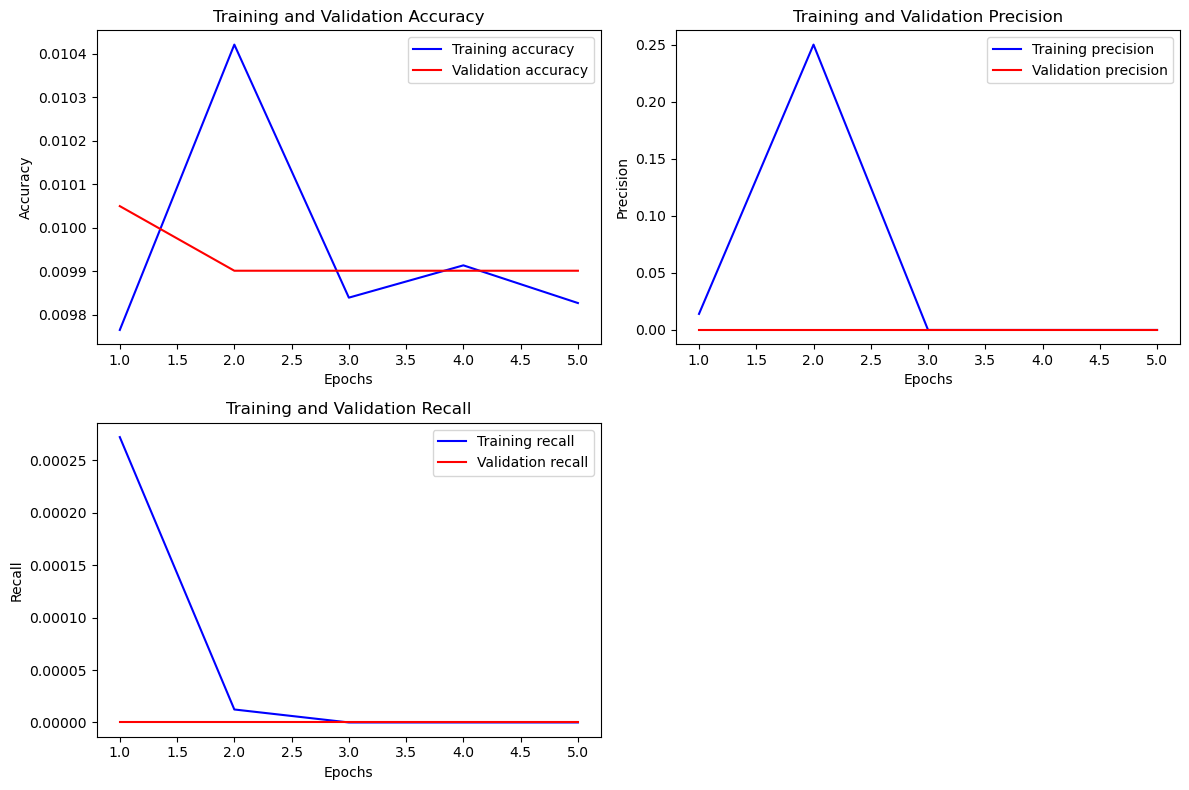

In [22]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.1.1 Model_4 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.00001\
regularization: l2 0.0005\
characteristics: overfitting?? try a lower lr with regularization added

In [23]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Flatten(),
        
        layers.Dense(256, kernel_regularizer=l2(.0005), activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.0005), activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, kernel_regularizer=l2(.0005), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [24]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    68,660,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,707,941 (262.10 MB)

 Trainable params: 68,707,941 (262.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 101s 39ms/step - accuracy: 0.0097 - loss: 5.1352 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0111 - val_loss: 4.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0099 - loss: 5.0686 - precision: 0.0437 - recall: 4.8039e-05 - val_accuracy: 0.0125 - val_loss: 4.9892 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0122 - loss: 5.0480 - precision: 0.0217 - recall: 3.0168e-05 - val_accuracy: 0.0179 - val_loss: 4.9644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0138 - loss: 5.0273 - precision: 0.0521 - recall: 7.7035e-05 - val_accuracy: 0.0197 - val_loss: 4.9502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0139 - loss: 5.0018 - prec

In [25]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0286 - loss: 4.9331 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.9334235191345215
Validation Accuracy: 0.018564356490969658
Validation Precision: 0.0
Validation Recall: 0.0


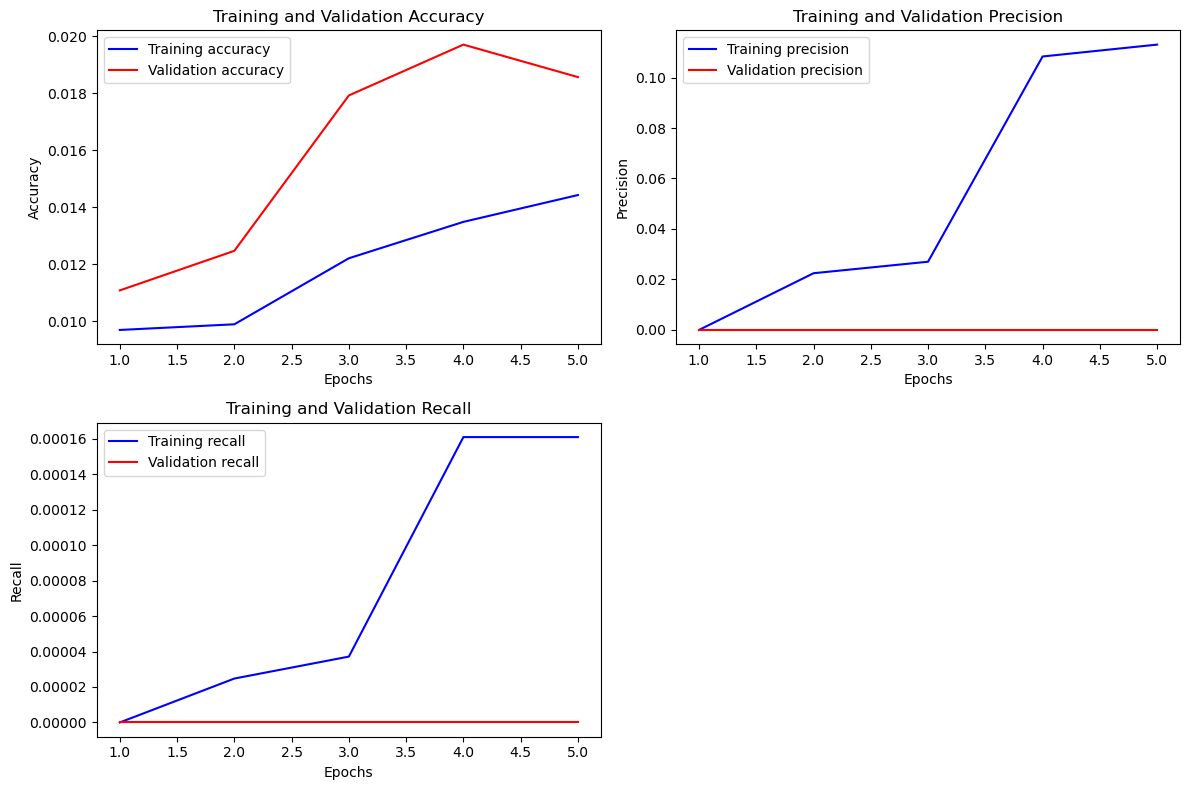

In [26]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.1.1 Model_4 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.00001\
regularization: l2 0.005\
characteristics: more aggressive regularization

In [27]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Flatten(),
        
        layers.Dense(256, kernel_regularizer=l2(.005), activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.005), activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, kernel_regularizer=l2(.005), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [28]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    68,660,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,707,941 (262.10 MB)

 Trainable params: 68,707,941 (262.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - accuracy: 0.0104 - loss: 8.4567 - precision: 0.0080 - recall: 8.3688e-06 - val_accuracy: 0.0115 - val_loss: 7.8241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0109 - loss: 7.7202 - precision: 0.0010 - recall: 1.2673e-06 - val_accuracy: 0.0130 - val_loss: 7.1370 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0114 - loss: 7.0539 - precision: 0.0583 - recall: 6.6096e-05 - val_accuracy: 0.0153 - val_loss: 6.5822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0125 - loss: 6.5295 - precision: 0.0838 - recall: 9.3964e-05 - val_accuracy: 0.0180 - val_loss: 6.1787 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 100s 39ms/step - accuracy: 0.0151 - loss: 6.1503 - precisi

In [29]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0202 - loss: 5.8935 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 5.900566101074219
Validation Accuracy: 0.018465345725417137
Validation Precision: 0.0
Validation Recall: 0.0


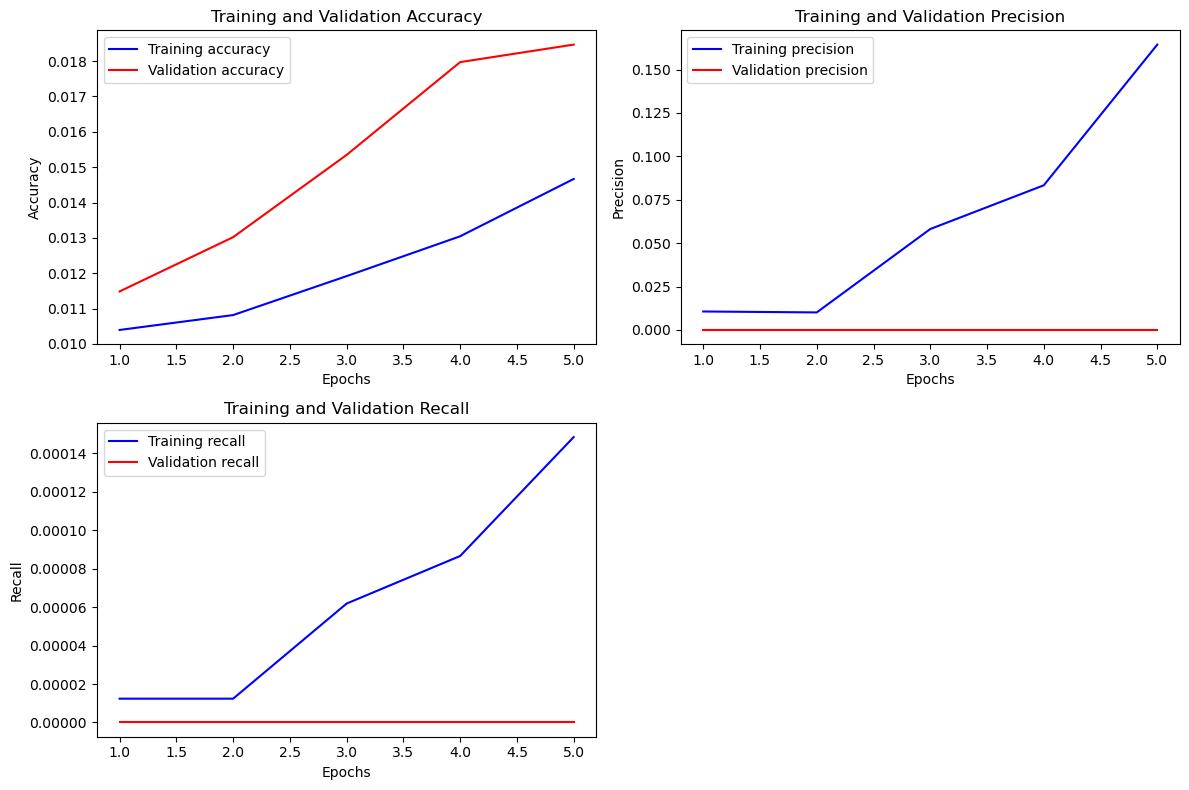

In [30]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.1.1 Model_4 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2 0.005\
characteristics: more aggressive learning rate & regularizaiton

In [27]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Flatten(),
        
        layers.Dense(256, kernel_regularizer=l2(.005), activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.005), activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, kernel_regularizer=l2(.005), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [31]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    68,660,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,707,941 (262.10 MB)

 Trainable params: 68,707,941 (262.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - accuracy: 0.0095 - loss: 12.6671 - precision: 0.0093 - recall: 7.9465e-04 - val_accuracy: 0.0099 - val_loss: 5.1581 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0088 - loss: 4.9772 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0092 - loss: 4.6268 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0091 - loss: 4.6159 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0092 - loss: 4.61

In [32]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0224 - loss: 4.6137 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.615206241607666
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


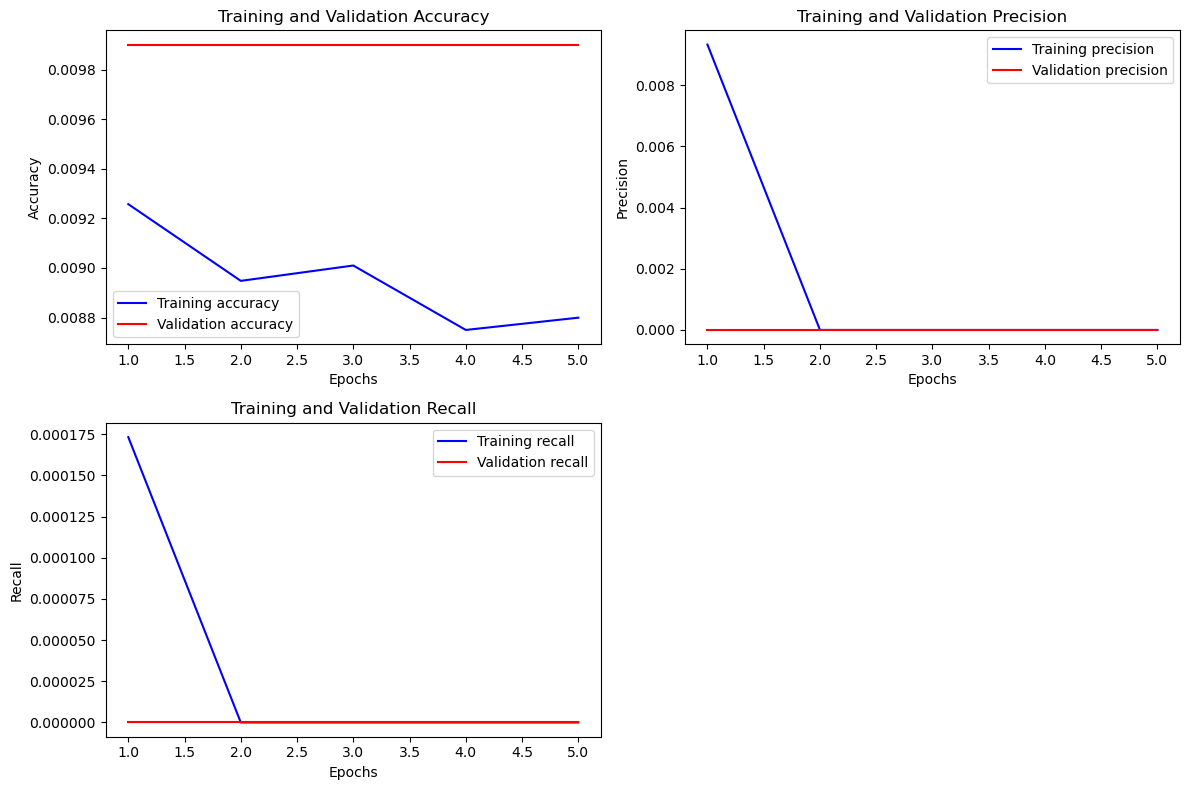

In [33]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.1.1 Model_4 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.000001\
regularization: l2 0.00005\
characteristics: going the other way, even smaller learning rate and regularization

In [34]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Flatten(),
        
        layers.Dense(256, kernel_regularizer=l2(.00005), activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.00005), activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, kernel_regularizer=l2(.00005), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [35]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.000001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    68,660,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,707,941 (262.10 MB)

 Trainable params: 68,707,941 (262.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - accuracy: 0.0114 - loss: 4.7052 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0139 - val_loss: 4.6421 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0120 - loss: 4.6629 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0160 - val_loss: 4.6380 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0142 - loss: 4.6579 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0183 - val_loss: 4.6357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0138 - loss: 4.6555 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0218 - val_loss: 4.6327 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0145 - loss: 4

In [36]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0262 - loss: 4.6286 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.63220739364624
Validation Accuracy: 0.019900990650057793
Validation Precision: 0.0
Validation Recall: 0.0


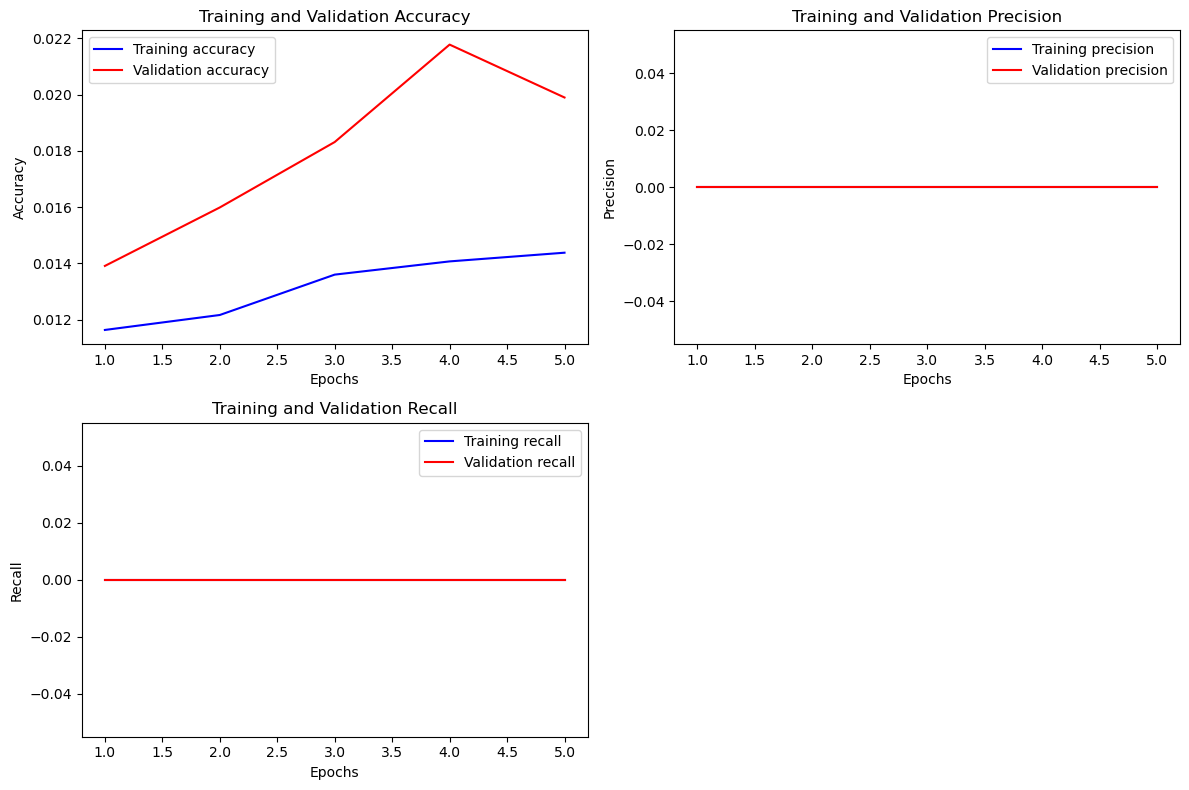

In [37]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.1.1 Model_4 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.00005\
regularization: l2 0.0002\
characteristics: random guess for hyprparams

In [38]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),


        layers.Flatten(),
        
        layers.Dense(256, kernel_regularizer=l2(.0002), activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.0002), activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, kernel_regularizer=l2(.0002), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [39]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00005, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    68,660,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,707,941 (262.10 MB)

 Trainable params: 68,707,941 (262.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - accuracy: 0.0113 - loss: 5.3218 - precision: 0.0119 - recall: 2.4132e-04 - val_accuracy: 0.0132 - val_loss: 4.7923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0120 - loss: 4.9140 - precision: 0.0541 - recall: 1.2446e-04 - val_accuracy: 0.0114 - val_loss: 4.7894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0118 - loss: 4.8309 - precision: 0.1443 - recall: 2.8251e-05 - val_accuracy: 0.0100 - val_loss: 4.7765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0105 - loss: 4.7927 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0100 - val_loss: 4.7483 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0097 - loss: 4.7550 - prec

In [40]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0017 - loss: 4.7164 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.714970588684082
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


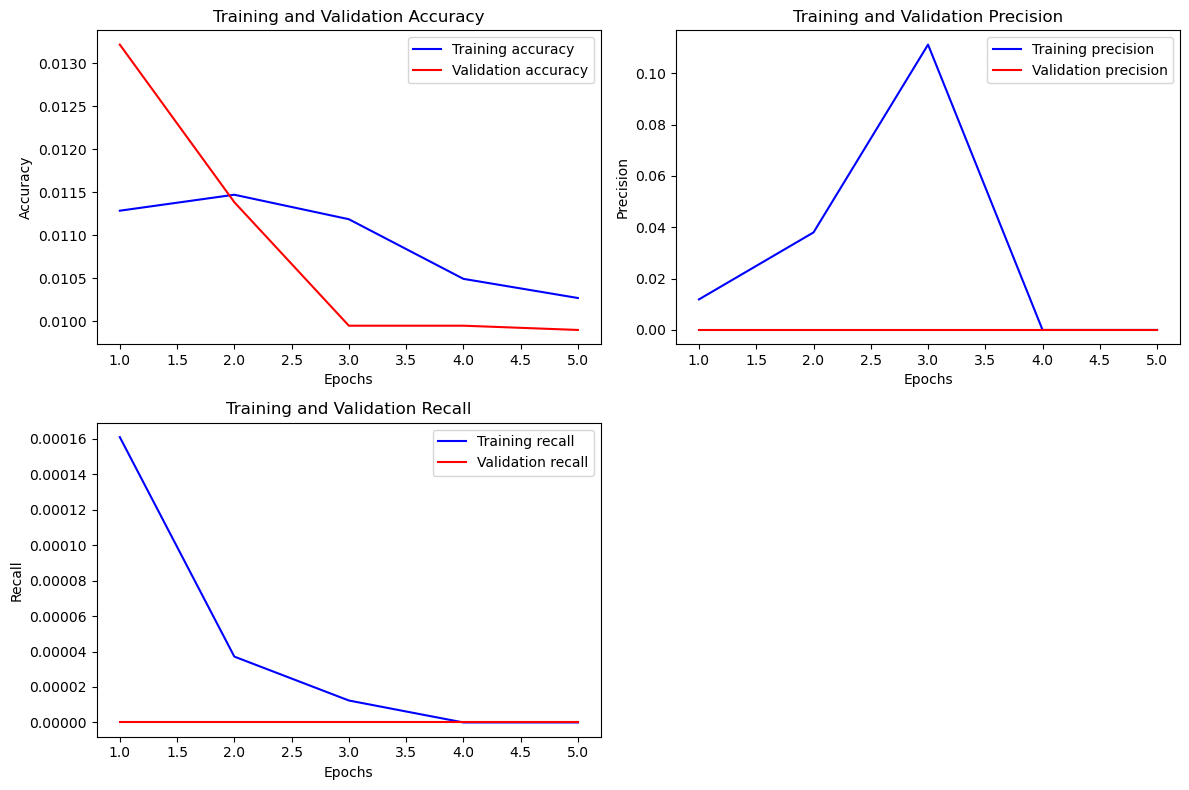

In [41]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


### 4.2 Neural Network: Model_5: more dense layer

#### 4.2.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2 0.0001\
characteristics: baseline model with sensible hyprparams

In [11]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(512, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        
        layers.Dense(256, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [17]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   137,320,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,503,077 (524.53 MB)

 Trainable params: 137,501,285 (524.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/5


I0000 00:00:1745906906.533198  262039 service.cc:152] XLA service 0x76d40c005ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745906906.533245  262039 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-04-29 02:08:26.602336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745906907.056478  262039 cuda_dnn.cc:529] Loaded cuDNN version 90800


   3/2525 ━━━━━━━━━━━━━━━━━━━━ 1:48 43ms/step - accuracy: 0.0000e+00 - loss: 5.1825 - precision: 0.0000e+00 - recall: 0.0000e+00 

I0000 00:00:1745906909.282690  262039 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 127s 48ms/step - accuracy: 0.0111 - loss: 5.0349 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0219 - val_loss: 4.7557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0154 - loss: 4.8505 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0287 - val_loss: 4.6822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0198 - loss: 4.7639 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0368 - val_loss: 4.6272 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0251 - loss: 4.7010 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0393 - val_loss: 4.5833 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0282 - loss: 4.6669 

In [18]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0407 - loss: 4.5695 - precision: 0.0853 - recall: 1.3508e-05
Validation Loss: 4.552336692810059
Validation Accuracy: 0.04297029599547386
Validation Precision: 0.6666666865348816
Validation Recall: 9.900989971356466e-05


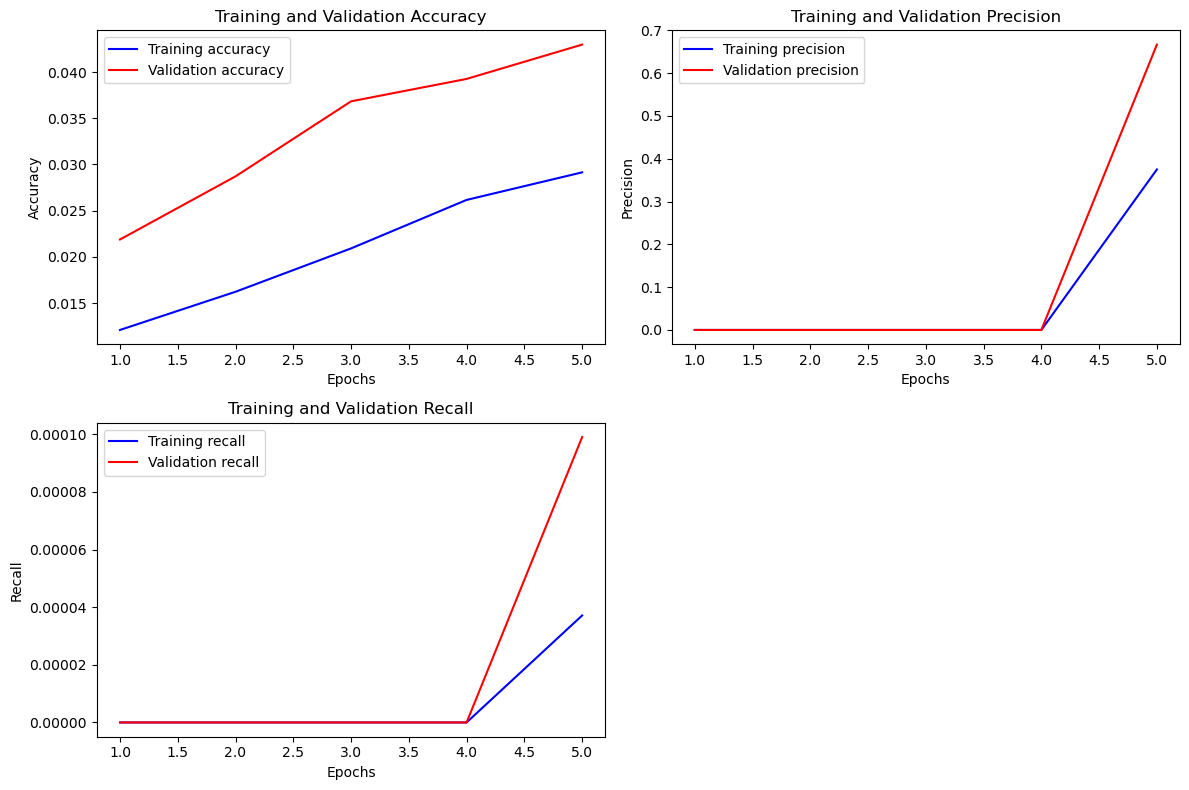

In [19]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.2.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2 0.0001\
characteristics: underfitting, increase lr

In [20]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(512, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        
        layers.Dense(256, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [21]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │   137,320,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,503,077 (524.53 MB)

 Trainable params: 137,501,285 (524.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 125s 48ms/step - accuracy: 0.0158 - loss: 5.1410 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0333 - val_loss: 4.7342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0283 - loss: 4.7908 - precision: 0.2146 - recall: 5.9186e-06 - val_accuracy: 0.0419 - val_loss: 4.7749 - val_precision: 0.5000 - val_recall: 9.9010e-05
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0333 - loss: 4.8371 - precision: 0.3746 - recall: 5.5911e-05 - val_accuracy: 0.0394 - val_loss: 4.8286 - val_precision: 0.2500 - val_recall: 9.9010e-05
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0331 - loss: 4.8815 - precision: 0.3607 - recall: 1.1076e-04 - val_accuracy: 0.0466 - val_loss: 4.8670 - val_precision: 0.6250 - val_recall: 2.4752e-04
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0342 - loss: 4.8951 - precision: 0

In [22]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0392 - loss: 4.8066 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.787281036376953
Validation Accuracy: 0.04465346410870552
Validation Precision: 0.0
Validation Recall: 0.0


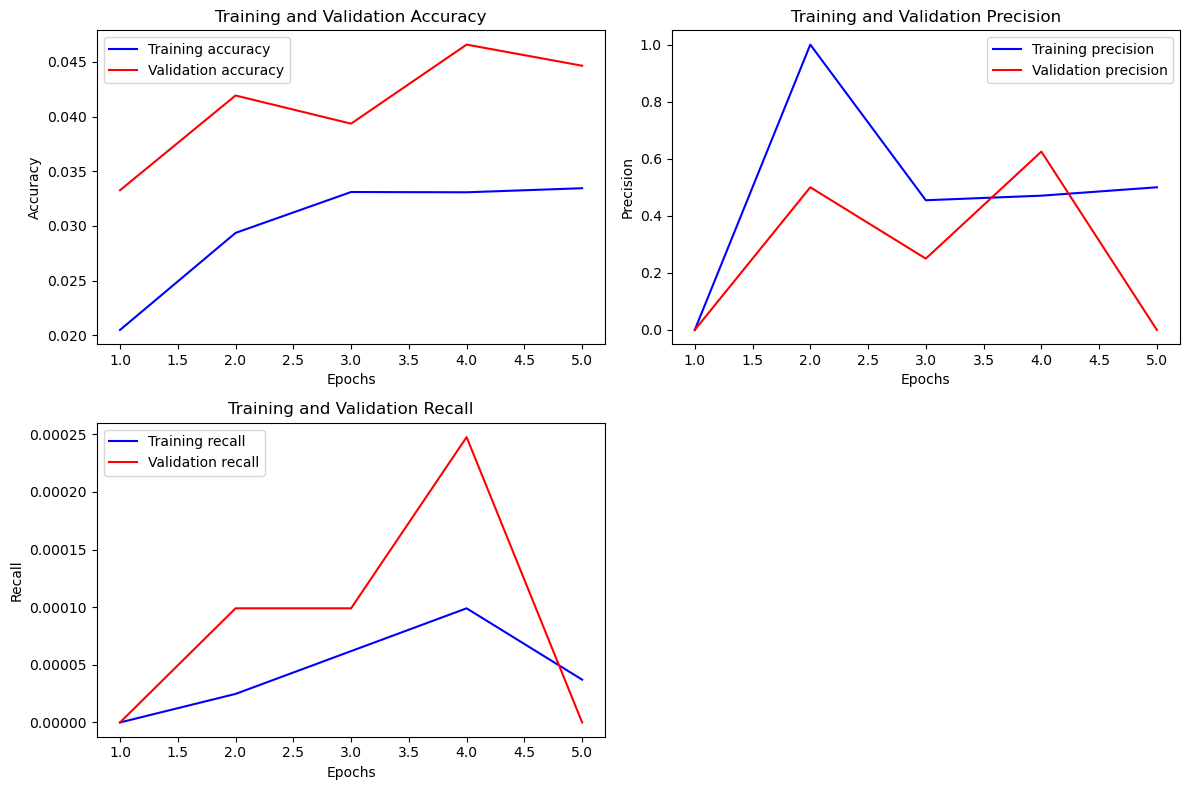

In [23]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.2.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2 0.001\
characteristics: increase regularization

In [11]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(512, kernel_regularizer=l2(.001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        
        layers.Dense(256, kernel_regularizer=l2(.001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [12]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   137,320,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,503,077 (524.53 MB)

 Trainable params: 137,501,285 (524.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/5


I0000 00:00:1745909955.766915  285315 service.cc:152] XLA service 0x7453e40053a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745909955.766959  285315 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-04-29 02:59:15.857599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745909956.145674  285315 cuda_dnn.cc:529] Loaded cuDNN version 90800


   5/2525 ━━━━━━━━━━━━━━━━━━━━ 1:42 41ms/step - accuracy: 0.0171 - loss: 6.7750 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1745909958.470774  285315 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 128s 49ms/step - accuracy: 0.0150 - loss: 6.7820 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0275 - val_loss: 5.2714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0230 - loss: 5.2554 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0323 - val_loss: 5.1152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0237 - loss: 5.2364 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0273 - val_loss: 5.2301 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0239 - loss: 5.3017 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0234 - val_loss: 5.2787 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0230 - loss: 5.2810 

In [13]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0343 - loss: 5.5426 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 5.549744129180908
Validation Accuracy: 0.027326732873916626
Validation Precision: 0.0
Validation Recall: 0.0


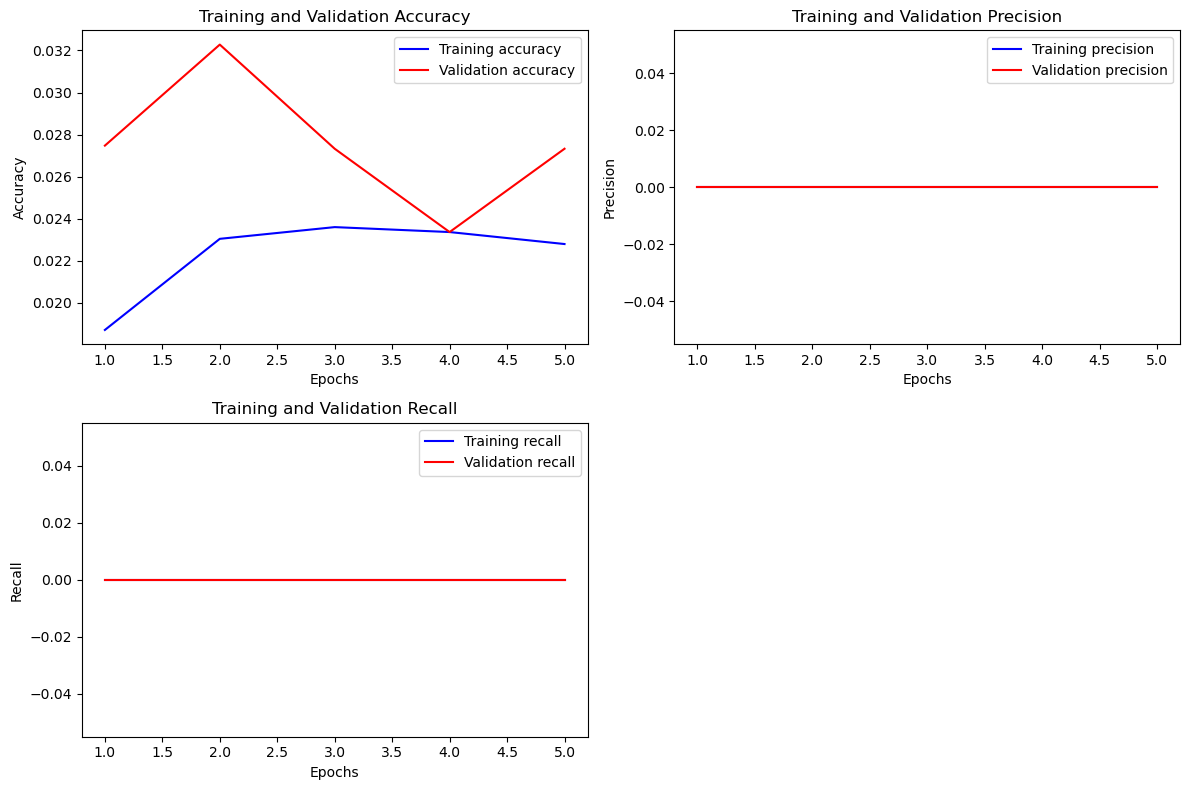

In [14]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.2.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.00001\
regularization: l2 0.0001\
characteristics: try a smaller learning rate

In [15]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(512, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        
        layers.Dense(256, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [16]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │   137,320,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,503,077 (524.53 MB)

 Trainable params: 137,501,285 (524.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 126s 48ms/step - accuracy: 0.0098 - loss: 5.1513 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0151 - val_loss: 4.8052 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 123s 48ms/step - accuracy: 0.0116 - loss: 5.0360 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0158 - val_loss: 4.7778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 123s 48ms/step - accuracy: 0.0123 - loss: 4.9783 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0198 - val_loss: 4.7585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 125s 49ms/step - accuracy: 0.0135 - loss: 4.9373 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0239 - val_loss: 4.7399 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.0141 - los

In [17]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0213 - loss: 4.7451 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.72417688369751
Validation Accuracy: 0.024603961035609245
Validation Precision: 0.0
Validation Recall: 0.0


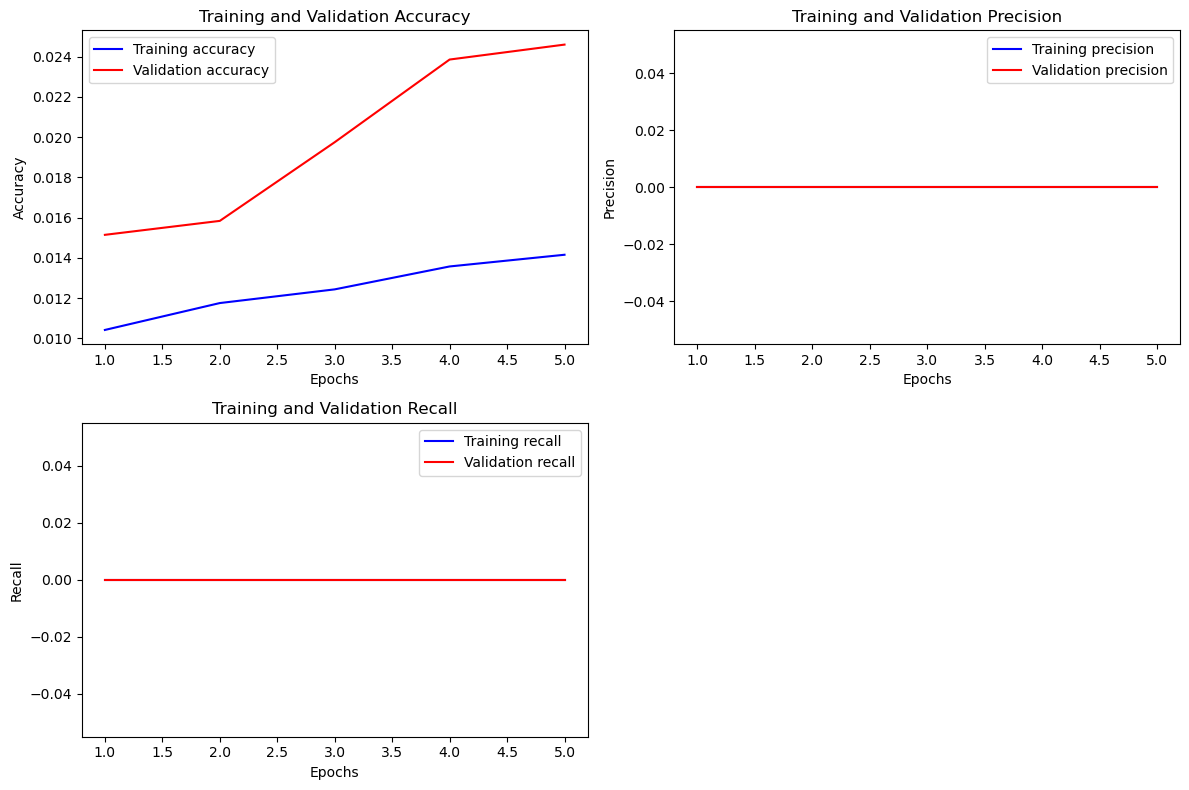

In [18]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.2.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.01\
regularization: l2 0.00001\
characteristics: try huge learning rate, very small regularization

In [19]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(512, kernel_regularizer=l2(.00001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        
        layers.Dense(256, kernel_regularizer=l2(.00001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.00001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.00001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [20]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.01, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │   137,320,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,503,077 (524.53 MB)

 Trainable params: 137,501,285 (524.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 125s 48ms/step - accuracy: 0.0125 - loss: 7.2241 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0161 - val_loss: 4.7336 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.0152 - loss: 4.7241 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0167 - val_loss: 4.7106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.0157 - loss: 4.7573 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0151 - val_loss: 4.7485 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.0152 - loss: 4.8427 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0148 - val_loss: 4.8946 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.0158 - los

In [21]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0188 - loss: 4.9145 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.925227165222168
Validation Accuracy: 0.015891090035438538
Validation Precision: 0.0
Validation Recall: 0.0


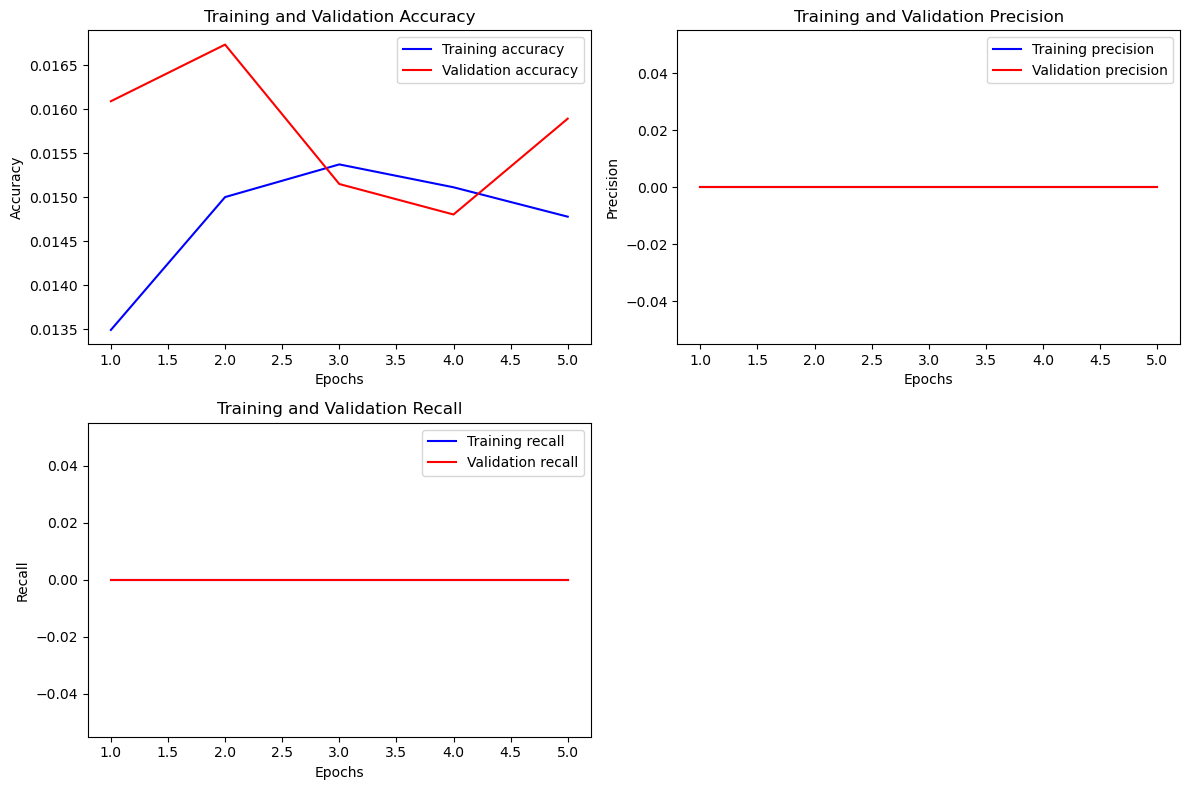

In [22]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.2.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.0005\
regularization: l2 0.01\
characteristics: try huge regularization

In [11]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(512, kernel_regularizer=l2(.01), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        
        layers.Dense(256, kernel_regularizer=l2(.01), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, kernel_regularizer=l2(.01), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.01), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [12]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0005, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   137,320,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,503,077 (524.53 MB)

 Trainable params: 137,501,285 (524.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/5


I0000 00:00:1745943130.510708  378269 service.cc:152] XLA service 0x7bb4ec012d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745943130.510732  378269 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-04-29 12:12:10.576489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745943130.825432  378269 cuda_dnn.cc:529] Loaded cuDNN version 90800


   5/2525 ━━━━━━━━━━━━━━━━━━━━ 1:41 40ms/step - accuracy: 0.0000e+00 - loss: 21.6160 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1745943133.033874  378269 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 126s 48ms/step - accuracy: 0.0115 - loss: 10.6833 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0168 - val_loss: 5.2048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 125s 49ms/step - accuracy: 0.0183 - loss: 5.2195 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0210 - val_loss: 5.3552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 128s 51ms/step - accuracy: 0.0203 - loss: 5.4807 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0196 - val_loss: 5.5271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 125s 50ms/step - accuracy: 0.0189 - loss: 5.5300 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0193 - val_loss: 5.3615 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 130s 51ms/step - accuracy: 0.0210 - loss: 5.5466

In [13]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.0175 - loss: 5.5156 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 5.5011444091796875
Validation Accuracy: 0.02331683225929737
Validation Precision: 0.0
Validation Recall: 0.0


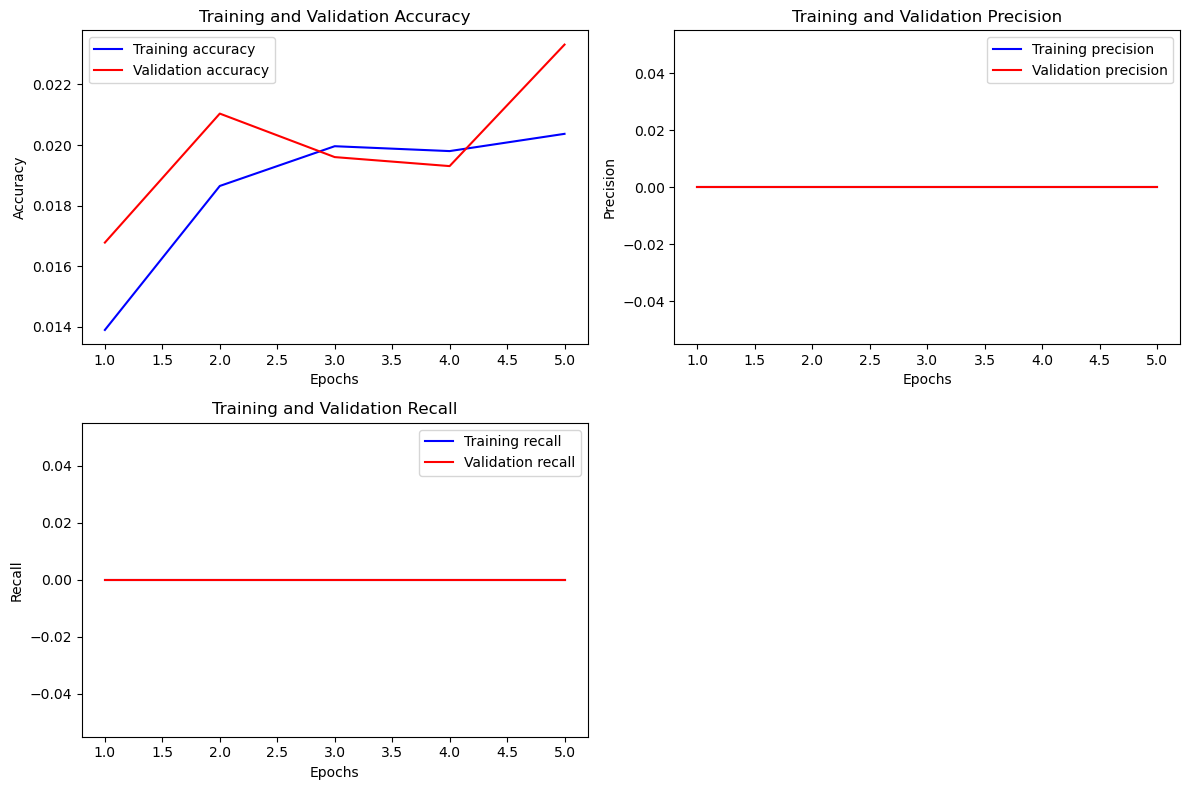

In [14]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


### 4.3 Neural Network: Model_5: final model

#### 4.3.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.0001\
regularization: l2 0.0005\
characteristics: baseline model for a third approach: the simplest nn possible, flatten then only one dense layer

In [16]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(128, kernel_regularizer=l2(.0005), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0005), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [17]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    34,330,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,345,445 (131.02 MB)

 Trainable params: 34,345,189 (131.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.0149 - loss: 4.9048 - precision: 0.0337 - recall: 1.3162e-06 - val_accuracy: 0.0395 - val_loss: 4.5819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.0311 - loss: 4.6590 - precision: 0.3307 - recall: 7.0534e-05 - val_accuracy: 0.0449 - val_loss: 4.4971 - val_precision: 0.8667 - val_recall: 6.4356e-04
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.0342 - loss: 4.5943 - precision: 0.4675 - recall: 2.1577e-04 - val_accuracy: 0.0508 - val_loss: 4.4674 - val_precision: 0.5333 - val_recall: 3.9604e-04
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 90s 35ms/step - accuracy: 0.0379 - loss: 4.5576 - precision: 0.5621 - recall: 5.6619e-04 - val_accuracy: 0.0500 - val_loss: 4.4431 - val_precision: 0.7895 - val_recall: 7.4257e-04
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 90s 35ms/step - accuracy: 0.0416 - loss: 4.5245 - precision: 0.5565 - r

In [18]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0440 - loss: 4.4484 - precision: 0.6083 - recall: 6.2921e-04
Validation Loss: 4.424151420593262
Validation Accuracy: 0.052178218960762024
Validation Precision: 0.8333333134651184
Validation Recall: 0.0007425742805935442


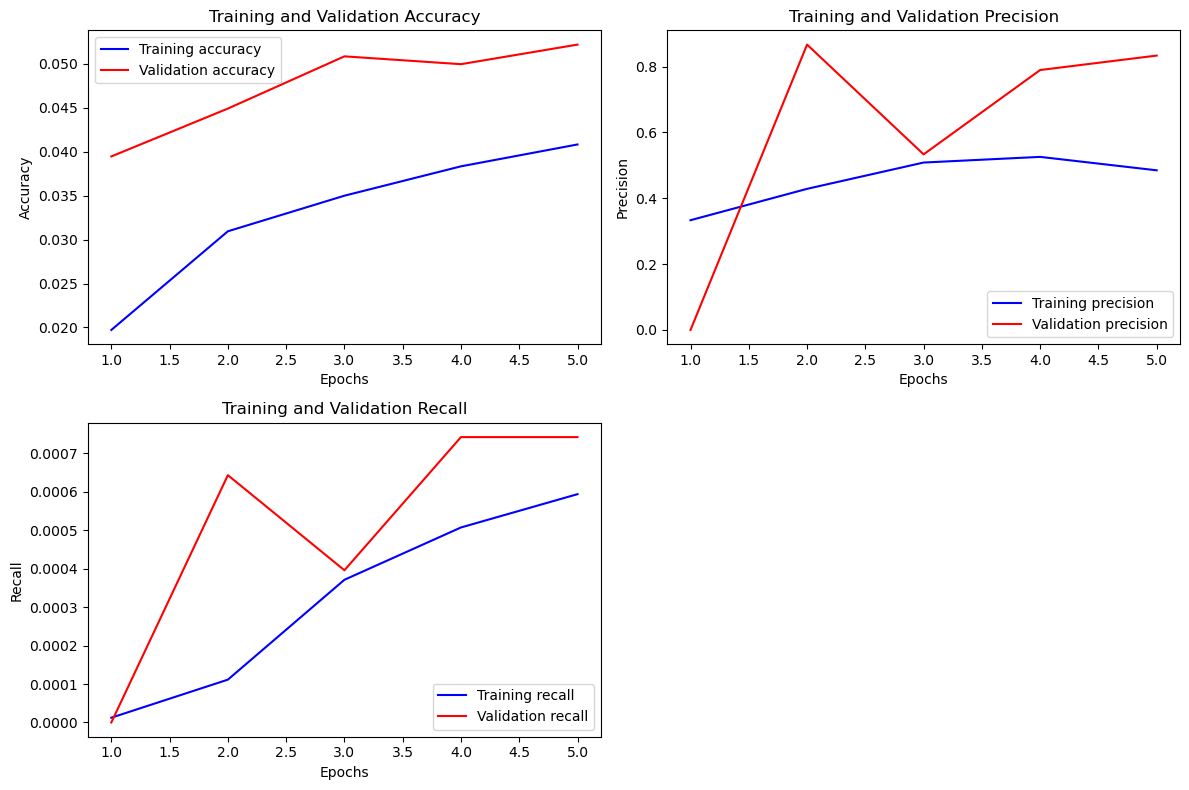

In [19]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.3.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2 0.0005\
characteristics: more lr

In [16]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(128, kernel_regularizer=l2(.0005), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0005), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [20]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    34,330,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,345,445 (131.02 MB)

 Trainable params: 34,345,189 (131.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 97s 37ms/step - accuracy: 0.0198 - loss: 5.0247 - precision: 0.0551 - recall: 2.4565e-06 - val_accuracy: 0.0395 - val_loss: 4.6601 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 100s 40ms/step - accuracy: 0.0330 - loss: 4.7181 - precision: 0.3620 - recall: 8.7677e-05 - val_accuracy: 0.0392 - val_loss: 4.6487 - val_precision: 1.0000 - val_recall: 9.9010e-05
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 100s 39ms/step - accuracy: 0.0330 - loss: 4.7400 - precision: 0.5324 - recall: 1.3180e-04 - val_accuracy: 0.0409 - val_loss: 4.6686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 100s 40ms/step - accuracy: 0.0351 - loss: 4.7238 - precision: 0.4122 - recall: 1.3045e-04 - val_accuracy: 0.0409 - val_loss: 4.6666 - val_precision: 1.0000 - val_recall: 2.9703e-04
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 101s 40ms/step - accuracy: 0.0346 - loss: 4.7222 - precision: 0.

In [21]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0322 - loss: 4.6904 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.663197040557861
Validation Accuracy: 0.03910890966653824
Validation Precision: 0.0
Validation Recall: 0.0


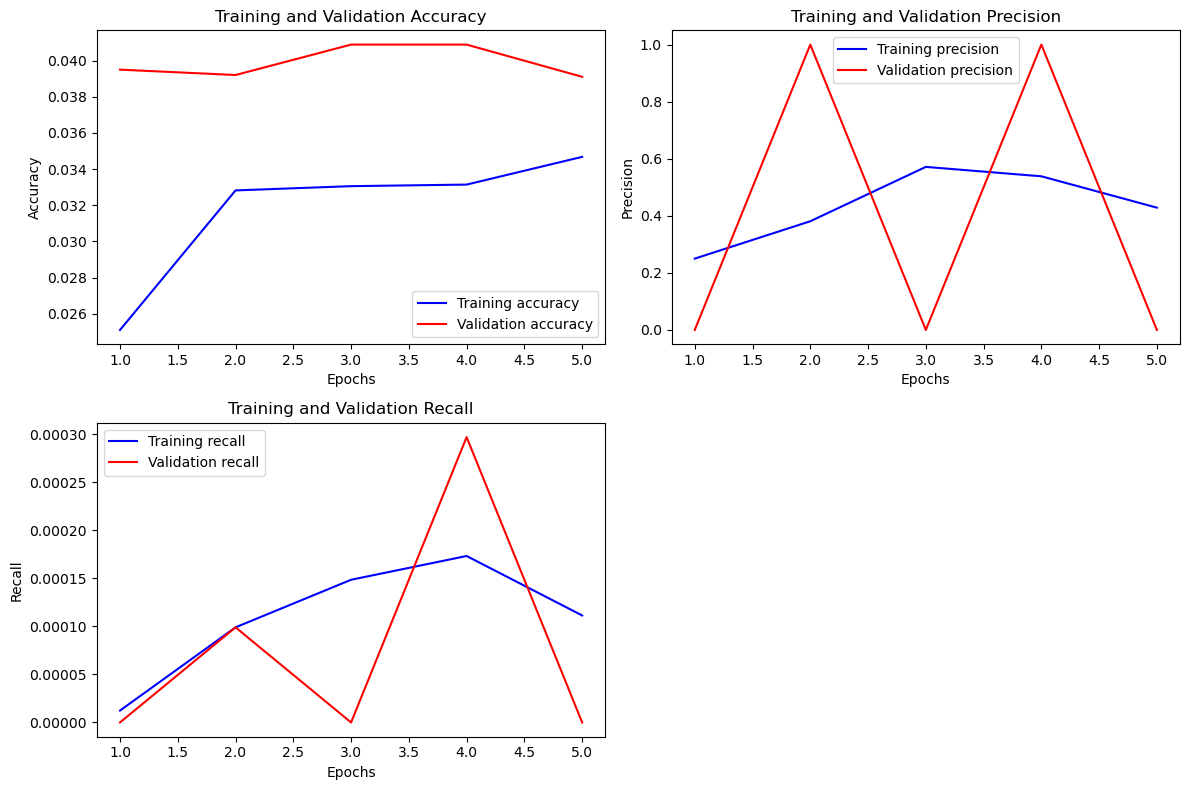

In [22]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.3.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.001\
regularization: l2 0.001\
characteristics: a bit more l2

In [23]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(128, kernel_regularizer=l2(.001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [24]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │    34,330,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,345,445 (131.02 MB)

 Trainable params: 34,345,189 (131.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - accuracy: 0.0176 - loss: 5.2134 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0314 - val_loss: 4.7449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.0312 - loss: 4.7859 - precision: 0.2516 - recall: 4.3308e-05 - val_accuracy: 0.0366 - val_loss: 4.7327 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.0317 - loss: 4.8046 - precision: 0.4922 - recall: 3.1192e-05 - val_accuracy: 0.0362 - val_loss: 4.7696 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.0312 - loss: 4.8231 - precision: 0.7033 - recall: 4.9818e-05 - val_accuracy: 0.0369 - val_loss: 4.7377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 90s 35ms/step - accuracy: 0.0327 - loss: 4.8135 - preci

In [25]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0399 - loss: 4.7366 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.728977203369141
Validation Accuracy: 0.040594059973955154
Validation Precision: 0.0
Validation Recall: 0.0


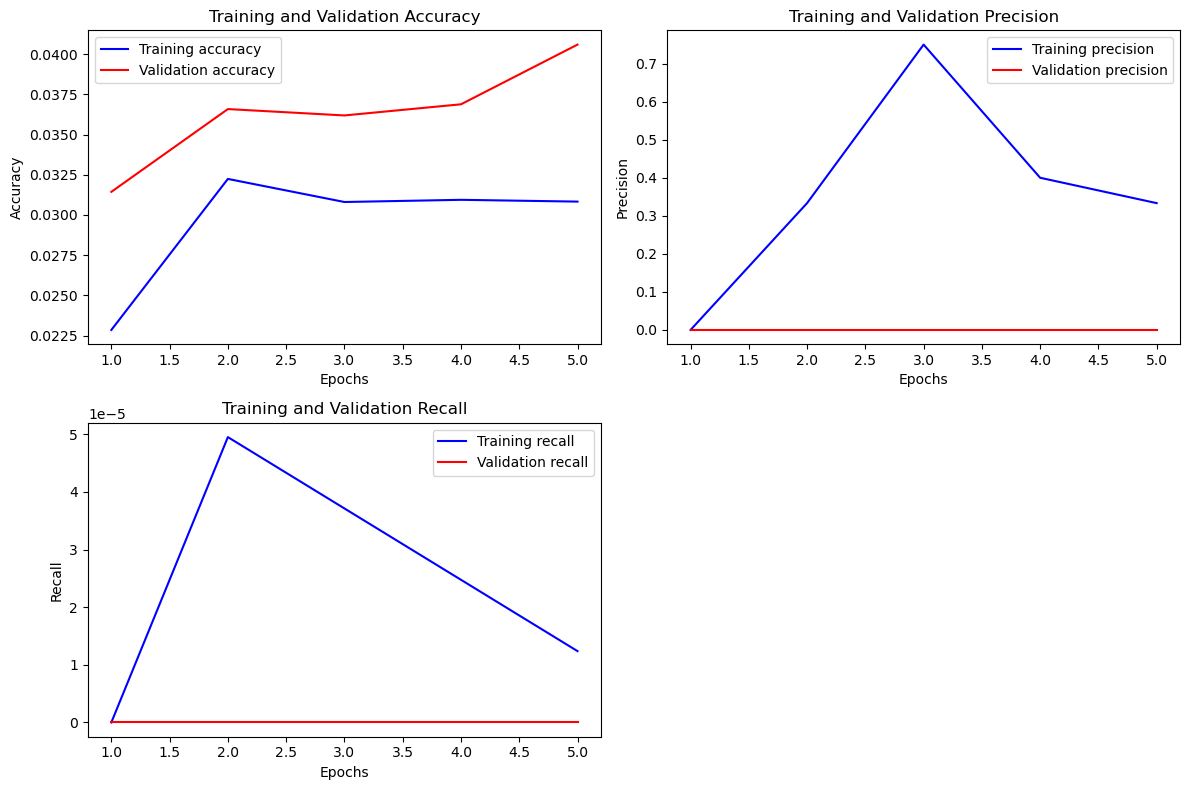

In [26]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.3.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.1\
regularization: l2 0.0001\
characteristics: try huge learning rate, regualar l2

In [27]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(128, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [28]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.1, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    34,330,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,345,445 (131.02 MB)

 Trainable params: 34,345,189 (131.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.0102 - loss: 75.2922 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6536 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 90s 35ms/step - accuracy: 0.0094 - loss: 4.6583 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6577 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 97s 38ms/step - accuracy: 0.0108 - loss: 4.6594 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0101 - loss: 4.6596 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0099 - val_loss: 4.6593 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0096 - loss: 4

In [29]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 9.0299e-04 - loss: 4.6661 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Loss: 4.657675743103027
Validation Accuracy: 0.009900989942252636
Validation Precision: 0.0
Validation Recall: 0.0


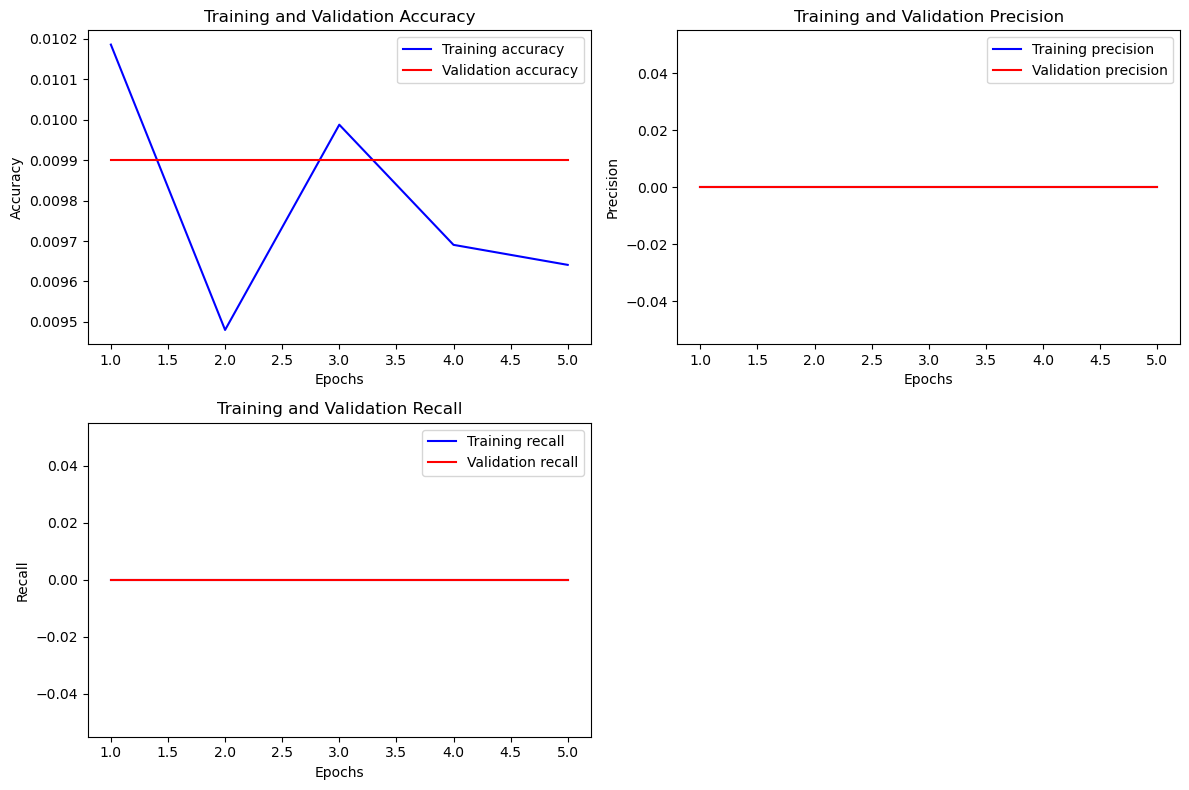

In [30]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.3.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.00001\
regularization: l2 0.0001\
characteristics: try very small learning rate

In [31]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(128, kernel_regularizer=l2(.0001), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [32]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │    34,330,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,345,445 (131.02 MB)

 Trainable params: 34,345,189 (131.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 100s 39ms/step - accuracy: 0.0125 - loss: 4.8959 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0286 - val_loss: 4.5930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 92s 36ms/step - accuracy: 0.0186 - loss: 4.7494 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0343 - val_loss: 4.5479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 97s 38ms/step - accuracy: 0.0233 - loss: 4.6844 - precision: 0.5650 - recall: 4.0025e-05 - val_accuracy: 0.0371 - val_loss: 4.5203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0251 - loss: 4.6471 - precision: 0.4188 - recall: 9.7786e-05 - val_accuracy: 0.0396 - val_loss: 4.4904 - val_precision: 0.7500 - val_recall: 1.4851e-04
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 98s 39ms/step - accuracy: 0.0275 - loss: 4.6105 - prec

In [33]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.0326 - loss: 4.5152 - precision: 0.0632 - recall: 3.3058e-05
Validation Loss: 4.468057155609131
Validation Accuracy: 0.04188118875026703
Validation Precision: 0.5
Validation Recall: 0.0002475247601978481


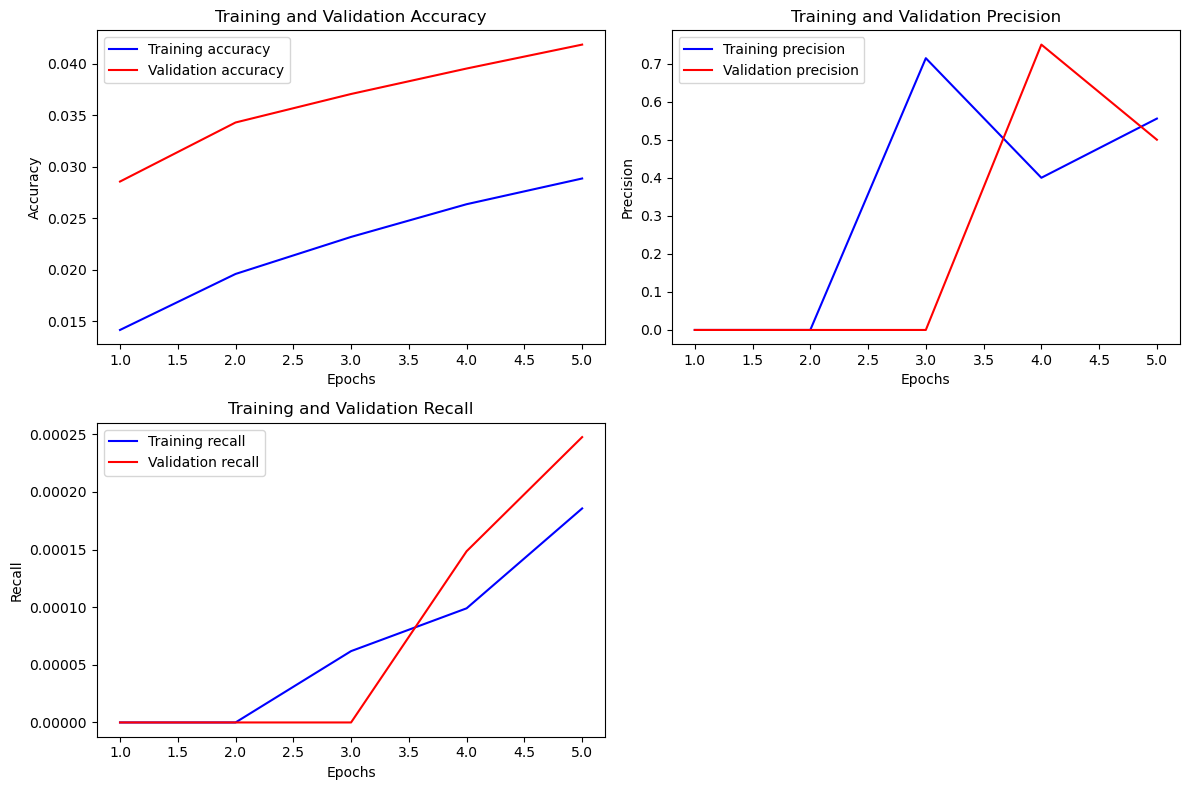

In [34]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.3.1 Model_5 definition ####
Variant: flatten layer NN, no conv layers\
optimizer: adam\
learning rate: 0.0003\
regularization: l2 0.0003\
characteristics: try huge regularization

In [35]:
# Model Definition
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(128, kernel_regularizer=l2(.0003), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, kernel_regularizer=l2(.0003), activation='relu'),
        layers.Dense(num_classes, activation='softmax')

        
    ])
    return model

In [36]:
# Create model
model = create_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0003, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │    34,330,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,345,445 (131.02 MB)

 Trainable params: 34,345,189 (131.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 100s 39ms/step - accuracy: 0.0190 - loss: 4.8216 - precision: 0.1825 - recall: 1.5974e-05 - val_accuracy: 0.0426 - val_loss: 4.5327 - val_precision: 0.6667 - val_recall: 3.9604e-04
Epoch 2/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0342 - loss: 4.6024 - precision: 0.3883 - recall: 3.6217e-04 - val_accuracy: 0.0485 - val_loss: 4.4957 - val_precision: 0.8824 - val_recall: 7.4257e-04
Epoch 3/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 98s 39ms/step - accuracy: 0.0397 - loss: 4.5623 - precision: 0.3855 - recall: 3.3833e-04 - val_accuracy: 0.0485 - val_loss: 4.4765 - val_precision: 0.7619 - val_recall: 7.9208e-04
Epoch 4/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.0418 - loss: 4.5384 - precision: 0.3895 - recall: 3.5677e-04 - val_accuracy: 0.0536 - val_loss: 4.4518 - val_precision: 0.6207 - val_recall: 8.9109e-04
Epoch 5/5
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 98s 39ms/step - accuracy: 0.0433 - loss: 4.5199 - precision: 0.3578 - reca

In [37]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


632/632 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.0481 - loss: 4.4512 - precision: 0.3516 - recall: 1.8459e-04
Validation Loss: 4.43137788772583
Validation Accuracy: 0.054950494319200516
Validation Precision: 0.6000000238418579
Validation Recall: 0.0002970297064166516


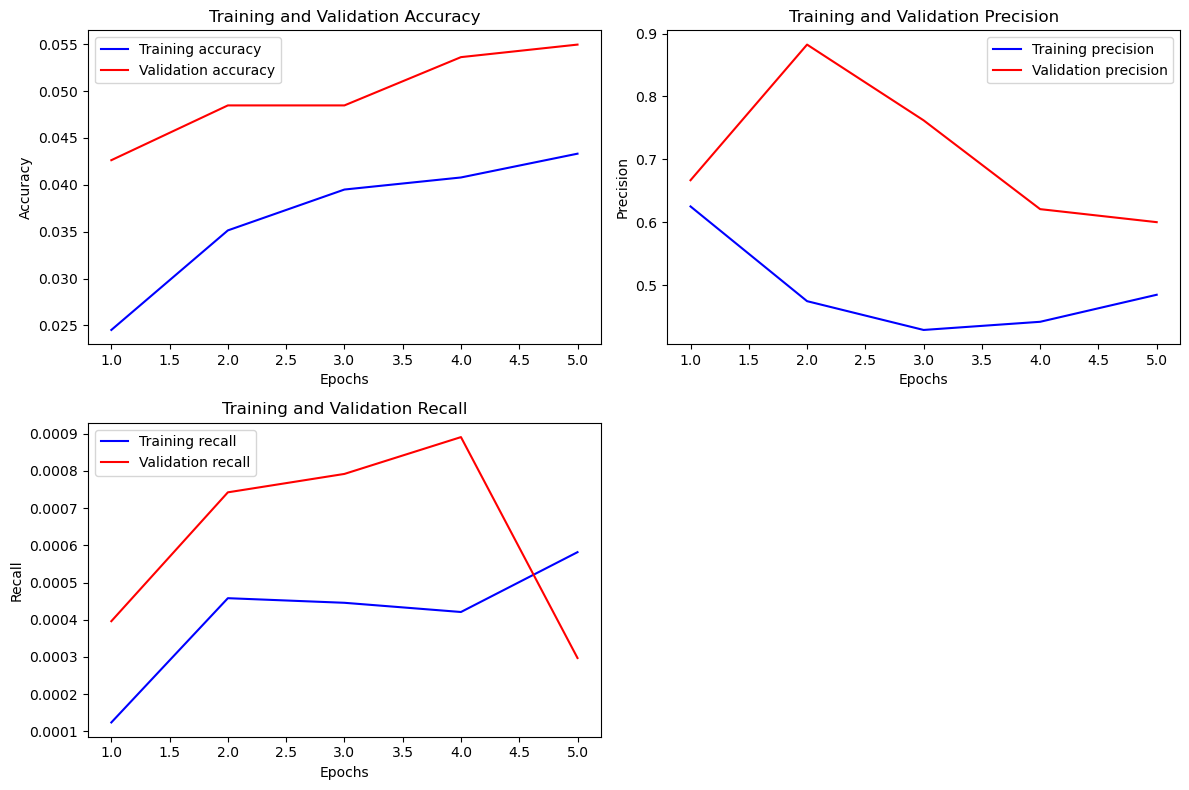

In [38]:


# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision']
val_prec = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


## 5. Supervised Analysis: SVM ##

### 5.1 Data Preprocessing and Augmentation ###

#### From the images properties, we can see that not all images are the same size. As a result, we will need to normalize the data and do a series of augmentations to help generalize the images ####

#### 5.1.1 Grabbing the validation set and getting the path to the trained features ####

In order to save time from rerunning the training data over and over, the features were stored in a file at this path. To regenerate this file, just delete the .npz files, which will cause the function to generate new ones

In [7]:
# path to training dataset

# CHANGE THIS TO FULL DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
train_path = 'food-101/train'

# List all 101 food categories
food_categories = [name for name in os.listdir(train_path)
                   if os.path.isdir(os.path.join(train_path, name))]

food_categories.sort()

total_images = 0

# Print total count + all food categories
print(f"\nTotal number of food categories: {len(food_categories)}")
print("Food categories:")
for category in food_categories:
    category_path = os.path.join(train_path, category)
    image_files = [f for f in os.listdir(category_path)
                   if os.path.isfile(os.path.join(category_path, f))]
    count = len(image_files)
    total_images += count
    print(f"- {category}: {count} images")

print(f"Total number of images: {total_images}")



Total number of food categories: 101
Food categories:
- apple_pie: 800 images
- baby_back_ribs: 800 images
- baklava: 800 images
- beef_carpaccio: 800 images
- beef_tartare: 800 images
- beet_salad: 800 images
- beignets: 800 images
- bibimbap: 800 images
- bread_pudding: 800 images
- breakfast_burrito: 800 images
- bruschetta: 800 images
- caesar_salad: 800 images
- cannoli: 800 images
- caprese_salad: 800 images
- carrot_cake: 800 images
- ceviche: 800 images
- cheese_plate: 800 images
- cheesecake: 800 images
- chicken_curry: 800 images
- chicken_quesadilla: 800 images
- chicken_wings: 800 images
- chocolate_cake: 800 images
- chocolate_mousse: 800 images
- churros: 800 images
- clam_chowder: 800 images
- club_sandwich: 800 images
- crab_cakes: 800 images
- creme_brulee: 800 images
- croque_madame: 800 images
- cup_cakes: 800 images
- deviled_eggs: 800 images
- donuts: 800 images
- dumplings: 800 images
- edamame: 800 images
- eggs_benedict: 800 images
- escargots: 800 images
- fal

In [14]:
val_dir = "food-101/validation"
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
TRAIN_FEATURES_PATH = "train_features.npz"
VAL_FEATURES_PATH = "val_features.npz"

#### 5.1.2 Data Augmentation

In [15]:
# May get an error about NUMA, can ignore
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    tf.keras.layers.Lambda(lambda x: tf.image.random_hue(x, 0.05)),
])

#### 5.1.3 Feature Extraction

In [16]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0  # normalize
    batch_size = tf.shape(x)[0]
    x = tf.reshape(x, [batch_size, -1])  # flatten
    return x, y


def extract_features(dataset):
    features, labels = [], []
    for images, lbls in tqdm(dataset.as_numpy_iterator(), desc="Extracting features"):
        features.append(images)  
        labels.append(lbls)
    return np.concatenate(features), np.concatenate(labels)

#### 5.1.4 Pipeline to Load and Extract Existing Features (and generate the features file if it does not exist)

In [17]:
def load_or_generate_features():
    if os.path.exists(TRAIN_FEATURES_PATH) and os.path.exists(VAL_FEATURES_PATH):
        print("🔁 Loading preprocessed features...")
        train_data = np.load(TRAIN_FEATURES_PATH)
        val_data = np.load(VAL_FEATURES_PATH)
        return train_data["X"], train_data["y"], val_data["X"], val_data["y"]

    print("📦 Preprocessing images and extracting features...")

    # Load and prepare datasets
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=True
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=False
    )

    # Augment and preprocess
    # train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    # Extract features
    X_train, y_train = extract_features(train_ds)
    X_val, y_val = extract_features(val_ds)

    # Save for reuse
    np.savez(TRAIN_FEATURES_PATH, X=X_train, y=y_train)
    np.savez(VAL_FEATURES_PATH, X=X_val, y=y_val)

    return X_train, y_train, X_val, y_val

In [18]:
X_train, y_train, X_val, y_val = load_or_generate_features()

# _, y_train, _, y_val = load_or_generate_features()
# X_train = train_pca
# X_val = val_pca

🔁 Loading preprocessed features...


In [ ]:
pca = PCA(n_components=300)  # or 500 or keep 95% variance
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

In [19]:
X_train = train_pca
X_val = val_pca

### 5.2 SVM with Poly Kernel, RBF Kernel, and PCA

In [46]:
def evaluate(param_grid):
    svc = SVC()
    grid = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=3)
    grid.fit(X_train, y_train)
    
    results = []

    for i, params in enumerate(grid.cv_results_['params']):
        model = grid.cv_results_['params'][i]
        
        svc = SVC(**model)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_val)
    
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
    
        results.append({
            'C': model['C'],
            'kernel': model['kernel'],
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })
    
    df_metrics = pd.DataFrame(results)

    metrics = ['accuracy', 'precision', 'recall', 'f1']

    train_scores = pd.DataFrame({
        'C': [params['C'] for params in grid.cv_results_['params']],
        'kernel': [params['kernel'] for params in grid.cv_results_['params']],
        'train_accuracy': grid.cv_results_['mean_train_score']
    })
    
    df_metrics = df_metrics.merge(train_scores, on=['C', 'kernel'])


    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        plt.figure(figsize=(8, 5))
        
        # Validation line
        sns.lineplot(data=df_metrics, x='C', y=metric, hue='kernel', marker='o')
    
        # Add training accuracy as dashed lines to only the accuracy plot
        if metric == 'accuracy':  
            sns.lineplot(
                data=df_metrics,
                x='C',
                y='train_accuracy',
                hue='kernel',
                style=True,
                dashes=[(2, 2)],
                legend=False  # Hide extra legend
            )
    
        plt.xscale('log')
        plt.title(f'{metric.capitalize()} vs C for each Kernel')
        plt.xlabel('C (log scale)')
        plt.ylabel(metric.capitalize())
        plt.grid(True)
        plt.legend(title='Kernel')
        plt.tight_layout()
        plt.show()


    print("\n Summary of Evaluation Metrics by Parameter Combination:\n")
    print(df_metrics.sort_values(by='f1', ascending=False).to_string(index=False))


In [47]:
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 100],
    'kernel': ['linear', 'poly', 'rbf']
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END C=0.01, kernel=linear;, score=(train=0.609, test=0.040) total time=  31.9s
[CV 2/3] END C=0.01, kernel=linear;, score=(train=0.608, test=0.036) total time=  32.2s
[CV 3/3] END C=0.01, kernel=linear;, score=(train=0.605, test=0.040) total time=  32.5s
[CV 1/3] END C=0.01, kernel=poly;, score=(train=0.045, test=0.017) total time=  31.8s
[CV 2/3] END C=0.01, kernel=poly;, score=(train=0.048, test=0.017) total time=  32.0s
[CV 3/3] END C=0.01, kernel=poly;, score=(train=0.056, test=0.016) total time=  32.1s
[CV 1/3] END C=0.01, kernel=rbf;, score=(train=0.087, test=0.030) total time=  36.6s
[CV 2/3] END C=0.01, kernel=rbf;, score=(train=0.078, test=0.029) total time=  36.7s
[CV 3/3] END C=0.01, kernel=rbf;, score=(train=0.082, test=0.031) total time=  36.4s
[CV 1/3] END C=0.1, kernel=linear;, score=(train=0.999, test=0.035) total time=  38.7s
[CV 2/3] END C=0.1, kernel=linear;, score=(train=0.999, test=0.035) total t

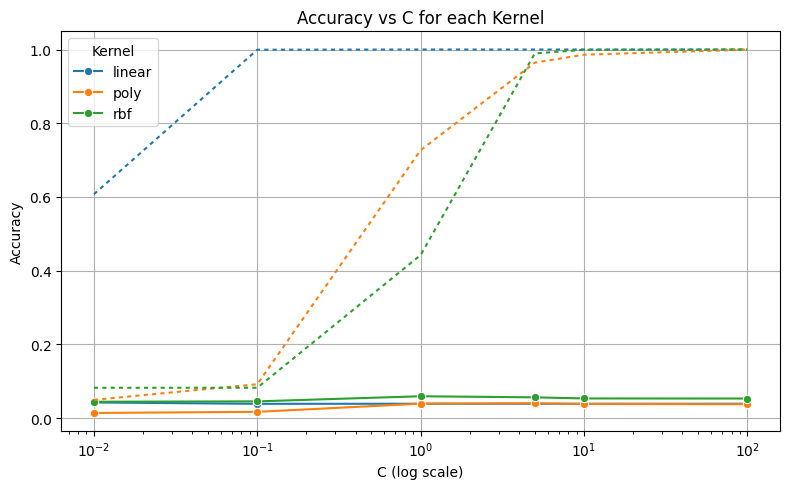

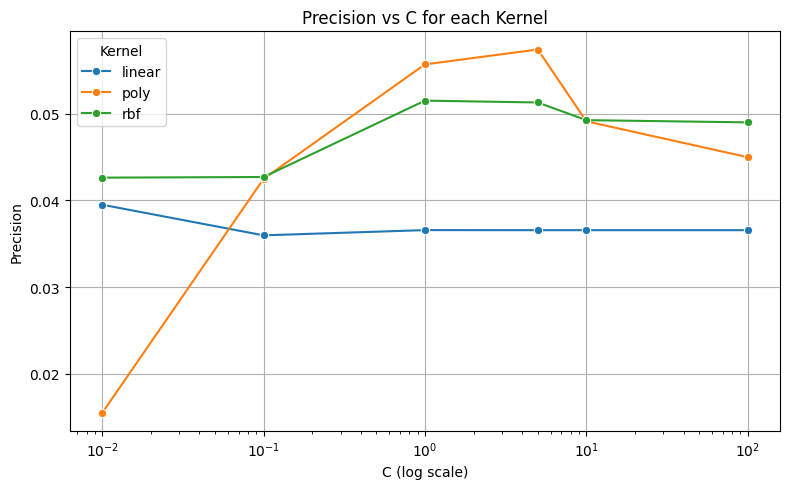

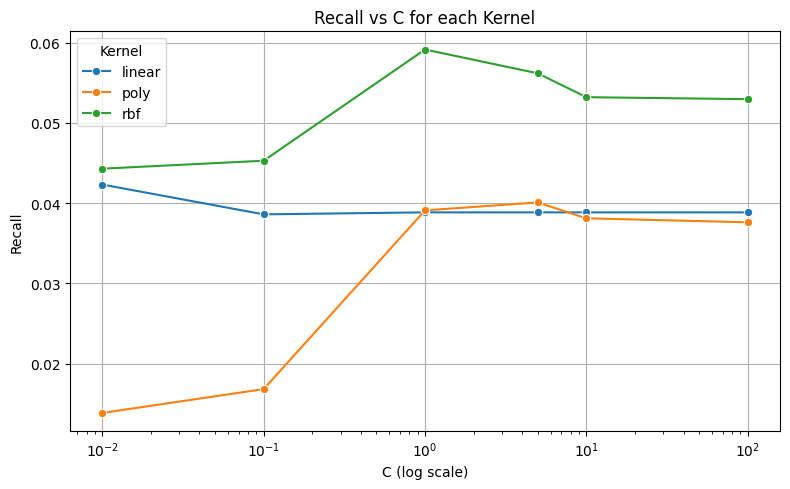

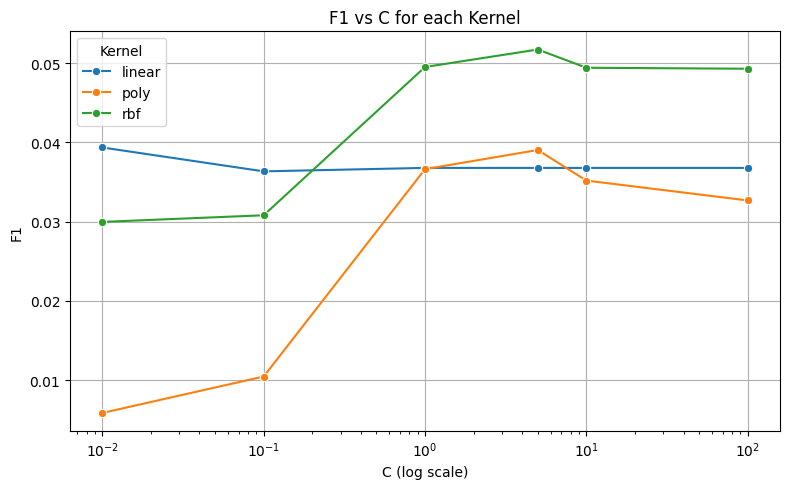


 Summary of Evaluation Metrics by Parameter Combination:

     C kernel  accuracy  precision   recall       f1  train_accuracy
  5.00    rbf  0.056188   0.051292 0.056188 0.051711        0.989326
  1.00    rbf  0.059158   0.051505 0.059158 0.049503        0.442296
 10.00    rbf  0.053218   0.049255 0.053218 0.049410        0.999196
100.00    rbf  0.052970   0.049000 0.052970 0.049285        1.000000
  0.01 linear  0.042327   0.039508 0.042327 0.039350        0.607364
  5.00   poly  0.040099   0.057397 0.040099 0.039034        0.964356
  1.00 linear  0.038861   0.036583 0.038861 0.036774        1.000000
 10.00 linear  0.038861   0.036575 0.038861 0.036772        1.000000
100.00 linear  0.038861   0.036575 0.038861 0.036772        1.000000
  5.00 linear  0.038861   0.036575 0.038861 0.036772        1.000000
  1.00   poly  0.039109   0.055683 0.039109 0.036617        0.726857
  0.10 linear  0.038614   0.035979 0.038614 0.036337        0.999443
 10.00   poly  0.038119   0.049122 0.038119 

In [48]:
evaluate(param_grid)